<a href="https://colab.research.google.com/github/mmtaha/Python_Aleatorio/blob/main/Projeto_Machine_Learning_AMAZON_ETL_BASICO_OU_ETL_ROBUSTO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install kagglehub pandas numpy scikit-learn matplotlib seaborn plotly xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

print("Bibliotecas importadas com sucesso!")

# Configurações de visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Bibliotecas importadas com sucesso!


In [16]:
# 2. CARREGAMENTO E PRÉ-ANÁLISE DOS DADOS
print("=== CARREGAMENTO DOS DADOS ===")

import kagglehub
from kagglehub import KaggleDatasetAdapter

ds = "ikramshah512/amazon-products-sales-dataset-42k-items-2025"
file_path = "amazon_products_sales_data_cleaned.csv"

# Carregar dataset
df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    ds,
    file_path
)

print(f"Shape inicial: {df.shape}")
print(f"Colunas: {df.columns.tolist()}")
print("\nPrimeiras linhas:")
print(df.head())

=== CARREGAMENTO DOS DADOS ===
Using Colab cache for faster access to the 'amazon-products-sales-dataset-42k-items-2025' dataset.
Shape inicial: (42675, 17)
Colunas: ['product_title', 'product_rating', 'total_reviews', 'purchased_last_month', 'discounted_price', 'original_price', 'is_best_seller', 'is_sponsored', 'has_coupon', 'buy_box_availability', 'delivery_date', 'sustainability_tags', 'product_image_url', 'product_page_url', 'data_collected_at', 'product_category', 'discount_percentage']

Primeiras linhas:
                                       product_title  product_rating  \
0  BOYA BOYALINK 2 Wireless Lavalier Microphone f...             4.6   
1  LISEN USB C to Lightning Cable, 240W 4 in 1 Ch...             4.3   
2  DJI Mic 2 (2 TX + 1 RX + Charging Case), Wirel...             4.6   
3  Apple AirPods Pro 2 Wireless Earbuds, Active N...             4.6   
4  Apple AirTag 4 Pack. Keep Track of and find Yo...             4.8   

   total_reviews  purchased_last_month  discounted

In [17]:
# 3. ANÁLISE EXPLORATÓRIA INICIAL
print("=== ANÁLISE EXPLORATÓRIA COMPLETA ===")

# Função para análise inicial do schema
def infer_schema(df):
    info = {c: {"dtype": str(df[c].dtype), "nnull": int(df[c].isna().sum()), "unique": int(df[c].nunique())} for c in df.columns}
    return info

schema = infer_schema(df)
print("Schema inicial:")
for col, info in schema.items():
    print(f"  {col}: {info}")

# Função para relatório de qualidade dos dados
def dq_report(df):
    return {
        "rows": len(df),
        "cols": df.shape[1],
        "nulls_pct": (df.isna().mean()*100).round(2).to_dict(),
        "duplicates": int(df.duplicated().sum())
    }

print("\nRelatório de Qualidade dos Dados:")
dq_info = dq_report(df)
for key, value in dq_info.items():
    print(f"  {key}: {value}")

=== ANÁLISE EXPLORATÓRIA COMPLETA ===
Schema inicial:
  product_title: {'dtype': 'object', 'nnull': 0, 'unique': 8808}
  product_rating: {'dtype': 'float64', 'nnull': 1024, 'unique': 31}
  total_reviews: {'dtype': 'float64', 'nnull': 1024, 'unique': 4413}
  purchased_last_month: {'dtype': 'float64', 'nnull': 10511, 'unique': 29}
  discounted_price: {'dtype': 'float64', 'nnull': 2062, 'unique': 3558}
  original_price: {'dtype': 'float64', 'nnull': 2062, 'unique': 3151}
  is_best_seller: {'dtype': 'object', 'nnull': 0, 'unique': 12}
  is_sponsored: {'dtype': 'object', 'nnull': 0, 'unique': 2}
  has_coupon: {'dtype': 'object', 'nnull': 0, 'unique': 42}
  buy_box_availability: {'dtype': 'object', 'nnull': 14653, 'unique': 1}
  delivery_date: {'dtype': 'object', 'nnull': 11983, 'unique': 24}
  sustainability_tags: {'dtype': 'object', 'nnull': 39267, 'unique': 16}
  product_image_url: {'dtype': 'object', 'nnull': 0, 'unique': 8038}
  product_page_url: {'dtype': 'object', 'nnull': 2069, 'uniq

In [18]:
# 4. LIMPEZA E PREPARAÇÃO DOS DADOS (ETL)
print("=== ETAPA DE ETL ===")

def basic_clean(df):
    df = df.copy()
    # Padronizar nomes das colunas
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

    # Converter para numéricos
    numeric_columns = ['discounted_price', 'actual_price', 'discount_percentage',
                      'product_rating', 'total_reviews', 'purchased_last_month']

    for col in numeric_columns:
        if col in df.columns:
            # Remover caracteres não numéricos e converter
            df[col] = pd.to_numeric(df[col].astype(str).str.replace(r'[^\d.-]', '', regex=True), errors='coerce')

    # Remover duplicatas
    df = df.drop_duplicates()
    return df

df_clean = basic_clean(df)
print(f"Shape após limpeza básica: {df_clean.shape}")

# Verificar se temos a coluna de data
date_columns = [col for col in df_clean.columns if 'date' in col or 'data' in col]
print(f"Colunas de data identificadas: {date_columns}")

if date_columns:
    df_clean[date_columns[0]] = pd.to_datetime(df_clean[date_columns[0]], errors='coerce')

=== ETAPA DE ETL ===
Shape após limpeza básica: (42675, 17)
Colunas de data identificadas: ['delivery_date', 'data_collected_at']


=== ANÁLISE EXPLORATÓRIA DETALHADA ===


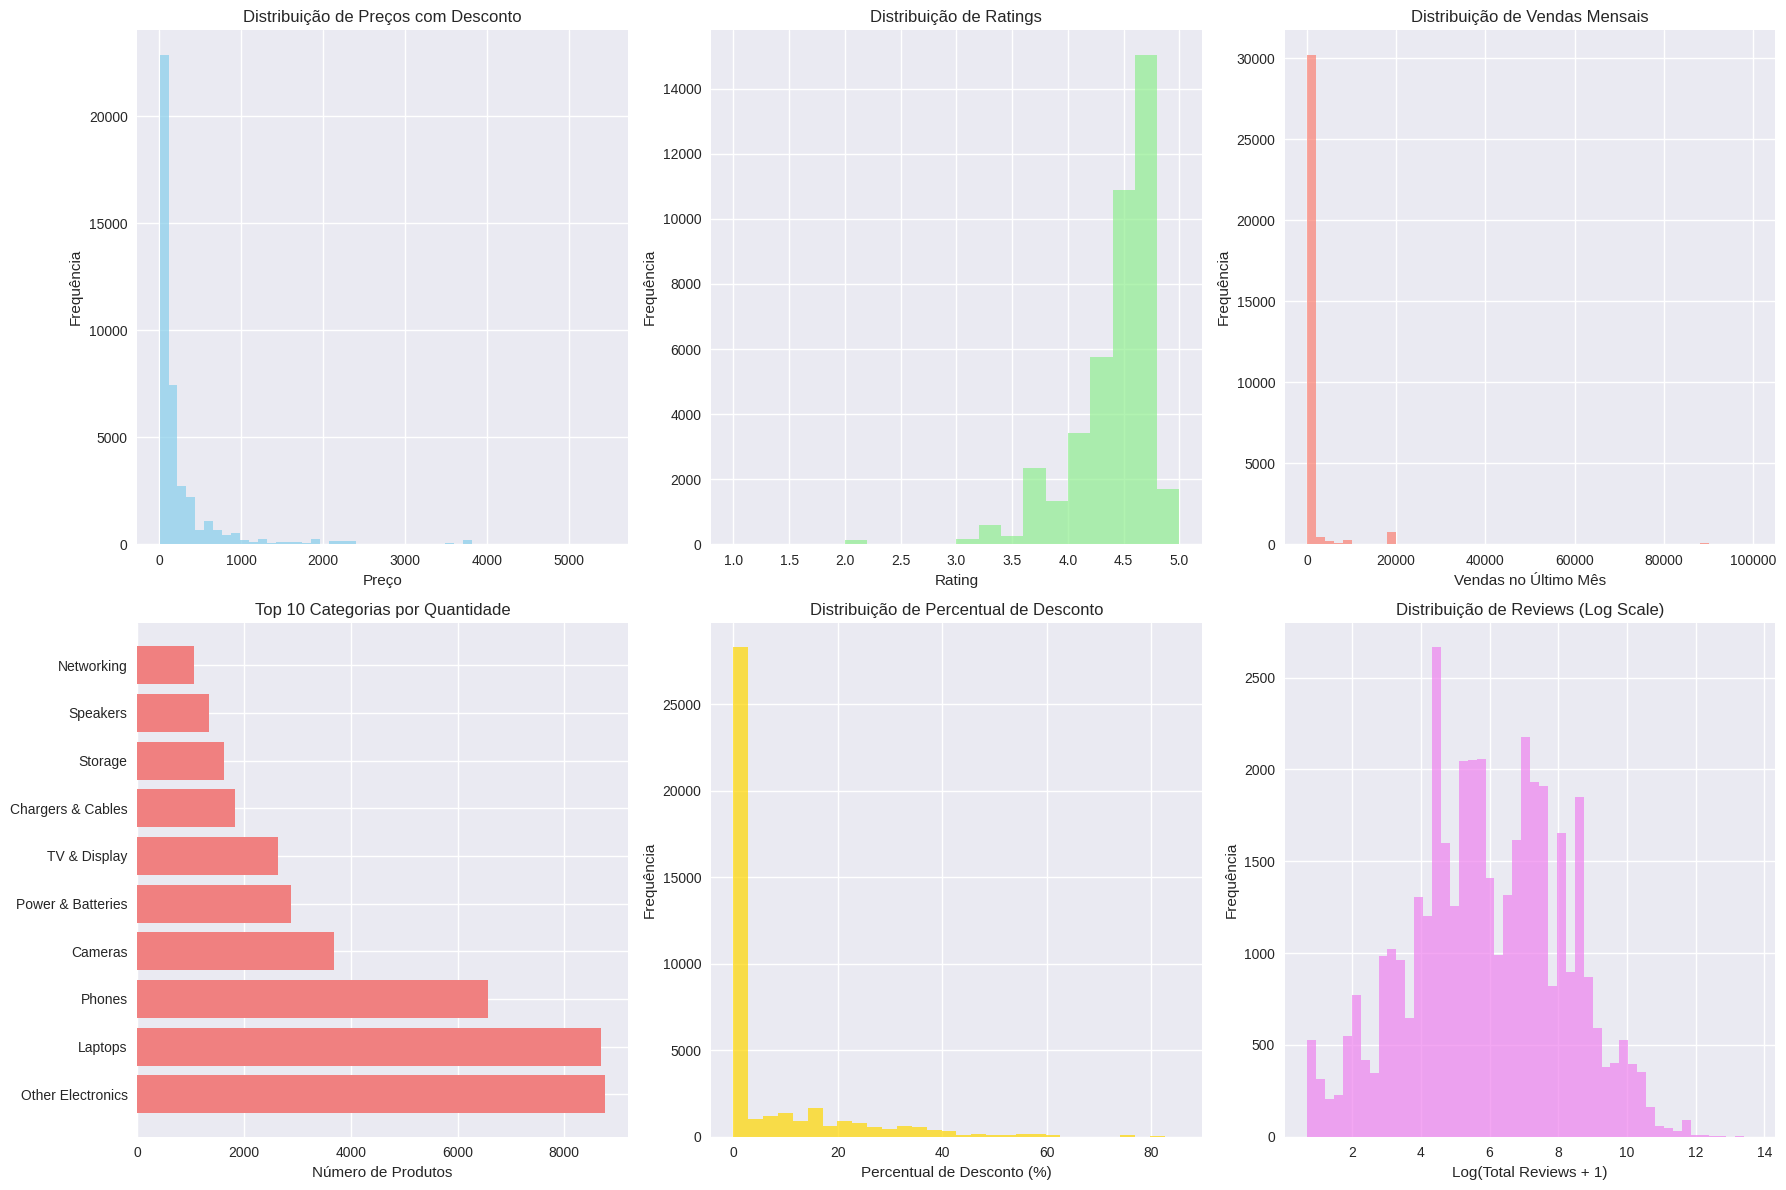

In [19]:
# 5. ANÁLISE EXPLORATÓRIA DETALHADA
print("=== ANÁLISE EXPLORATÓRIA DETALHADA ===")

# Criar subplots para análise distribucional
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Distribuição de preços com desconto
if 'discounted_price' in df_clean.columns:
    axes[0,0].hist(df_clean['discounted_price'].dropna(), bins=50, alpha=0.7, color='skyblue')
    axes[0,0].set_title('Distribuição de Preços com Desconto')
    axes[0,0].set_xlabel('Preço')
    axes[0,0].set_ylabel('Frequência')

# Distribuição de ratings
if 'product_rating' in df_clean.columns:
    axes[0,1].hist(df_clean['product_rating'].dropna(), bins=20, alpha=0.7, color='lightgreen')
    axes[0,1].set_title('Distribuição de Ratings')
    axes[0,1].set_xlabel('Rating')
    axes[0,1].set_ylabel('Frequência')

# Distribuição de vendas mensais
if 'purchased_last_month' in df_clean.columns:
    axes[0,2].hist(df_clean['purchased_last_month'].dropna(), bins=50, alpha=0.7, color='salmon')
    axes[0,2].set_title('Distribuição de Vendas Mensais')
    axes[0,2].set_xlabel('Vendas no Último Mês')
    axes[0,2].set_ylabel('Frequência')

# Top categorias por quantidade de produtos
if 'product_category' in df_clean.columns:
    top_categories = df_clean['product_category'].value_counts().head(10)
    axes[1,0].barh(range(len(top_categories)), top_categories.values, color='lightcoral')
    axes[1,0].set_yticks(range(len(top_categories)))
    axes[1,0].set_yticklabels(top_categories.index)
    axes[1,0].set_title('Top 10 Categorias por Quantidade')
    axes[1,0].set_xlabel('Número de Produtos')

# Distribuição de descontos
if 'discount_percentage' in df_clean.columns:
    axes[1,1].hist(df_clean['discount_percentage'].dropna(), bins=30, alpha=0.7, color='gold')
    axes[1,1].set_title('Distribuição de Percentual de Desconto')
    axes[1,1].set_xlabel('Percentual de Desconto (%)')
    axes[1,1].set_ylabel('Frequência')

# Distribuição de reviews
if 'total_reviews' in df_clean.columns:
    axes[1,2].hist(np.log1p(df_clean['total_reviews'].dropna()), bins=50, alpha=0.7, color='violet')
    axes[1,2].set_title('Distribuição de Reviews (Log Scale)')
    axes[1,2].set_xlabel('Log(Total Reviews + 1)')
    axes[1,2].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

=== ANÁLISE DE CORRELAÇÕES ===


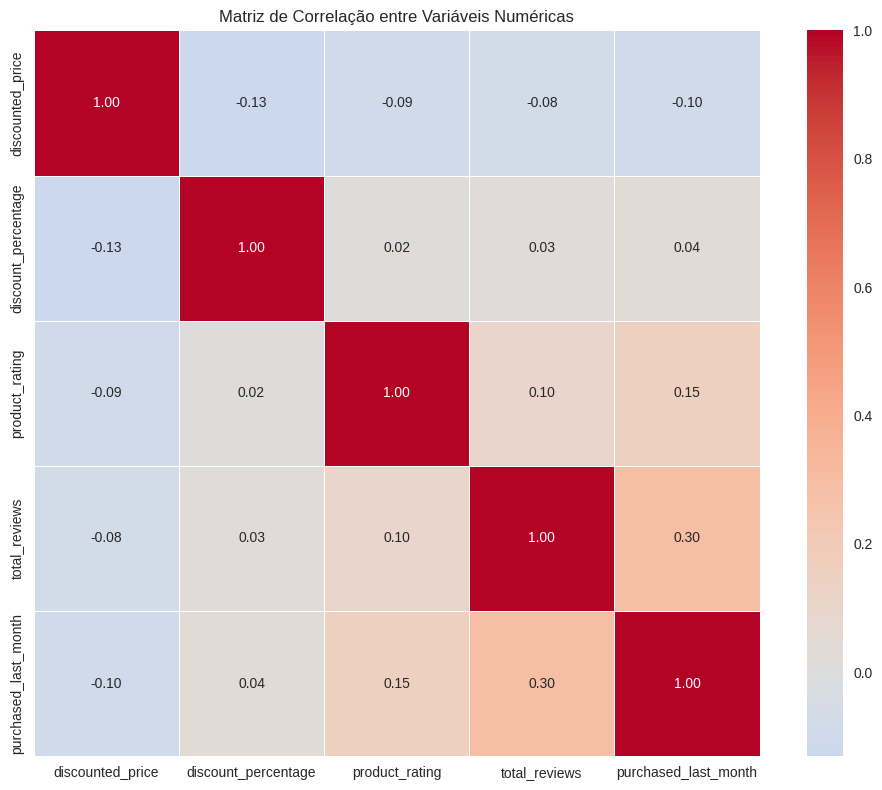

Correlações com Vendas Mensais:
purchased_last_month    1.000000
total_reviews           0.295952
product_rating          0.151883
discount_percentage     0.043190
discounted_price       -0.095635
Name: purchased_last_month, dtype: float64


In [20]:
# 6. ANÁLISE DE CORRELAÇÕES
print("=== ANÁLISE DE CORRELAÇÕES ===")

# Selecionar colunas numéricas para análise de correlação
numeric_cols = []
for col in ['discounted_price', 'actual_price', 'discount_percentage',
            'product_rating', 'total_reviews', 'purchased_last_month']:
    if col in df_clean.columns:
        numeric_cols.append(col)

if len(numeric_cols) > 1:
    correlation_matrix = df_clean[numeric_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5, fmt='.2f')
    plt.title('Matriz de Correlação entre Variáveis Numéricas')
    plt.tight_layout()
    plt.show()

    if 'purchased_last_month' in numeric_cols:
        print("Correlações com Vendas Mensais:")
        print(correlation_matrix['purchased_last_month'].sort_values(ascending=False))

=== ANÁLISE TEMPORAL ===


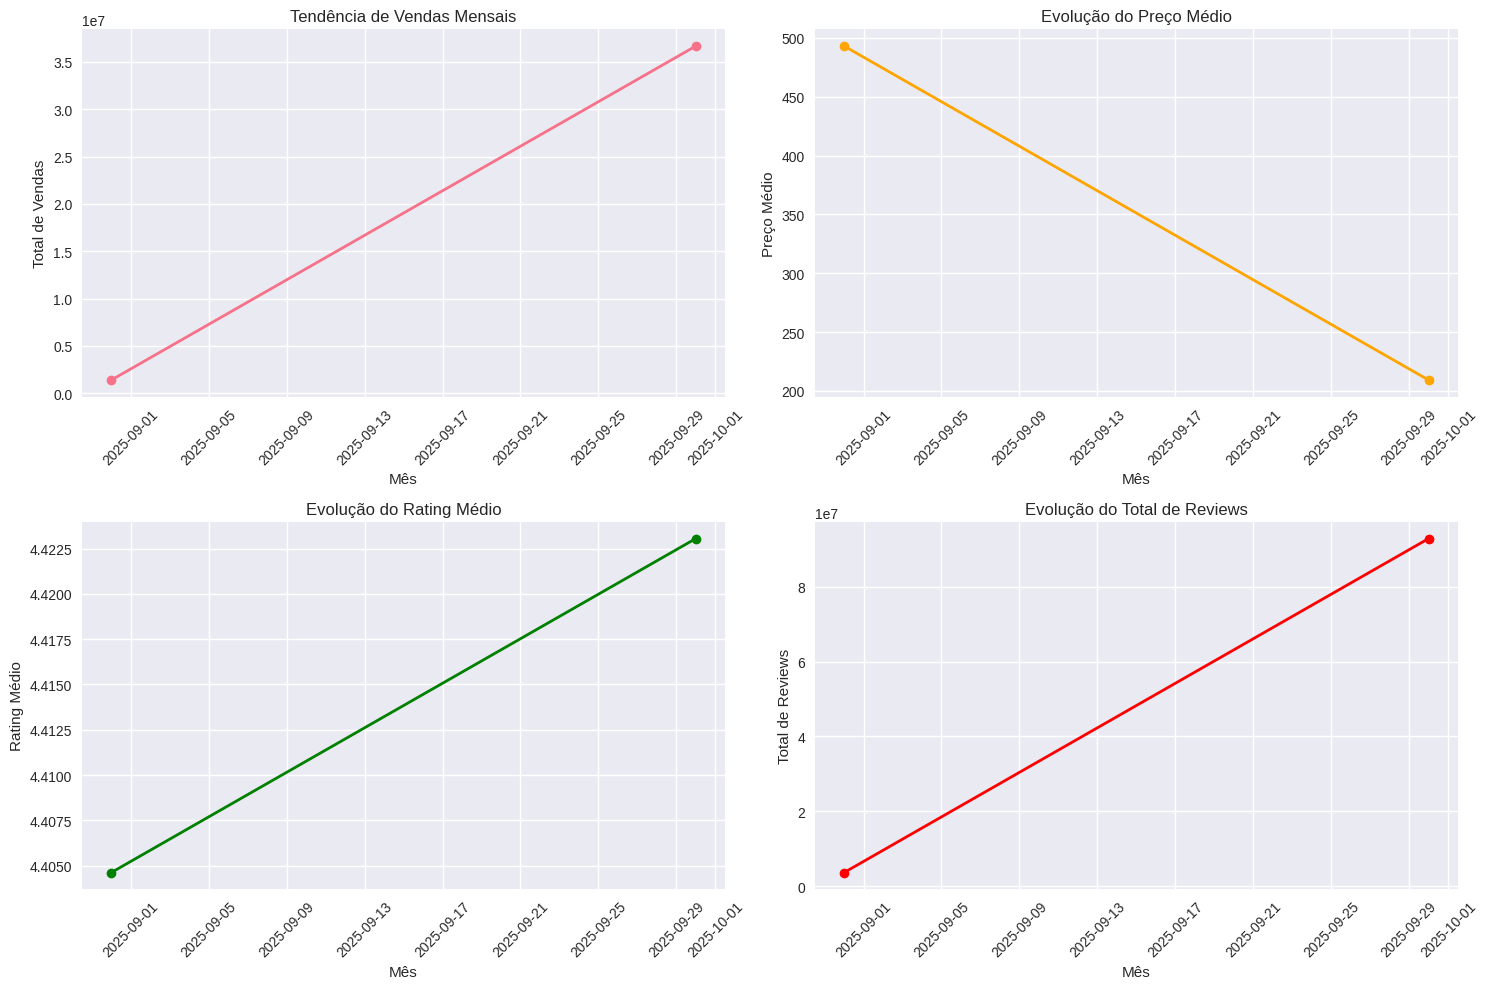

In [21]:
# 7. ANÁLISE TEMPORAL (se houver dados de data)
if date_columns:
    print("=== ANÁLISE TEMPORAL ===")

    monthly_trends = df_clean.groupby(pd.Grouper(key=date_columns[0], freq='M')).agg({
        'purchased_last_month': 'sum',
        'discounted_price': 'mean',
        'product_rating': 'mean',
        'total_reviews': 'sum'
    }).reset_index()

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Tendência de vendas mensais
    axes[0,0].plot(monthly_trends[date_columns[0]], monthly_trends['purchased_last_month'], marker='o', linewidth=2)
    axes[0,0].set_title('Tendência de Vendas Mensais')
    axes[0,0].set_xlabel('Mês')
    axes[0,0].set_ylabel('Total de Vendas')
    axes[0,0].tick_params(axis='x', rotation=45)

    # Tendência de preços médios
    axes[0,1].plot(monthly_trends[date_columns[0]], monthly_trends['discounted_price'], marker='o', color='orange', linewidth=2)
    axes[0,1].set_title('Evolução do Preço Médio')
    axes[0,1].set_xlabel('Mês')
    axes[0,1].set_ylabel('Preço Médio')
    axes[0,1].tick_params(axis='x', rotation=45)

    # Tendência de ratings
    axes[1,0].plot(monthly_trends[date_columns[0]], monthly_trends['product_rating'], marker='o', color='green', linewidth=2)
    axes[1,0].set_title('Evolução do Rating Médio')
    axes[1,0].set_xlabel('Mês')
    axes[1,0].set_ylabel('Rating Médio')
    axes[1,0].tick_params(axis='x', rotation=45)

    # Tendência de reviews
    axes[1,1].plot(monthly_trends[date_columns[0]], monthly_trends['total_reviews'], marker='o', color='red', linewidth=2)
    axes[1,1].set_title('Evolução do Total de Reviews')
    axes[1,1].set_xlabel('Mês')
    axes[1,1].set_ylabel('Total de Reviews')
    axes[1,1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

In [22]:
# 8. PREPARAÇÃO PARA MACHINE LEARNING
print("=== PREPARAÇÃO PARA MACHINE LEARNING ===")

def prepare_ml_data(df):
    ml_df = df.copy()

    # Engenharia de features
    if 'discounted_price' in ml_df.columns and 'product_rating' in ml_df.columns:
        ml_df['price_to_rating_ratio'] = ml_df['discounted_price'] / (ml_df['product_rating'] + 0.1)

    if 'total_reviews' in ml_df.columns and 'purchased_last_month' in ml_df.columns:
        ml_df['review_engagement'] = ml_df['total_reviews'] / (ml_df['purchased_last_month'] + 1)

    if 'discount_percentage' in ml_df.columns and 'purchased_last_month' in ml_df.columns:
        ml_df['discount_effectiveness'] = ml_df['discount_percentage'] * ml_df['purchased_last_month']

    # Selecionar features para o modelo
    features = []
    for col in ['discounted_price', 'actual_price', 'discount_percentage',
                'product_rating', 'total_reviews', 'price_to_rating_ratio',
                'review_engagement', 'discount_effectiveness']:
        if col in ml_df.columns:
            features.append(col)

    # Codificar variável categórica se existir
    if 'product_category' in ml_df.columns:
        le = LabelEncoder()
        ml_df['category_encoded'] = le.fit_transform(ml_df['product_category'].fillna('Unknown'))
        features.append('category_encoded')

    # Target variable
    target = 'purchased_last_month'

    # Remover linhas com valores missing
    ml_df = ml_df[features + [target]].dropna()

    return ml_df[features], ml_df[target], features

if 'purchased_last_month' in df_clean.columns:
    X, y, feature_names = prepare_ml_data(df_clean)
    print(f"Shape final para ML: X {X.shape}, y {y.shape}")
    print(f"Features utilizadas: {feature_names}")

# usar somente se houver colunas apropriadas
# print(ar_aging(df, due_date="due_date", payment_date="payment_date", invoice_col="invoice_value"))

=== PREPARAÇÃO PARA MACHINE LEARNING ===
Shape final para ML: X (30228, 8), y (30228,)
Features utilizadas: ['discounted_price', 'discount_percentage', 'product_rating', 'total_reviews', 'price_to_rating_ratio', 'review_engagement', 'discount_effectiveness', 'category_encoded']


In [28]:
# 9. MODELOS DE MACHINE LEARNING
print("=== MODELOS DE MACHINE LEARNING ===")

# Variáveis para armazenar resultados
best_model = None
best_model_name = None
results = {}

if 'purchased_last_month' in df_clean.columns and len(X) > 0:
    # Dividir os dados
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Modelos a serem testados
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'Linear Regression': LinearRegression()
    }

    for name, model in models.items():
        try:
            # Treinar modelo
            model.fit(X_train, y_train)

            # Fazer previsões
            y_pred = model.predict(X_test)

            # Calcular métricas
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            results[name] = {
                'model': model,
                'mse': mse,
                'r2': r2,
                'predictions': y_pred
            }

            print(f"{name}:")
            print(f"  MSE: {mse:.4f}")
            print(f"  R²: {r2:.4f}")
            print(f"  RMSE: {np.sqrt(mse):.4f}")

        except Exception as e:
            print(f"Erro ao treinar {name}: {e}")
            continue

    # Encontrar o melhor modelo
    if results:
        best_model_name = max(results.keys(), key=lambda x: results[x]['r2'])
        best_model = results[best_model_name]['model']
        print(f"\nMelhor modelo: {best_model_name} com R² = {results[best_model_name]['r2']:.4f}")
    else:
        print("Nenhum modelo foi treinado com sucesso.")
else:
    print("Condições não atendidas para treinamento de modelos:")
    print(f"  - 'purchased_last_month' presente: {'purchased_last_month' in df_clean.columns}")
    print(f"  - X tem dados: {len(X) > 0 if 'X' in locals() else 'X não definido'}")

=== MODELOS DE MACHINE LEARNING ===
Random Forest:
  MSE: 585299.6735
  R²: 0.9851
  RMSE: 765.0488
Gradient Boosting:
  MSE: 771244.6231
  R²: 0.9804
  RMSE: 878.2053
Linear Regression:
  MSE: 11418760.1894
  R²: 0.7094
  RMSE: 3379.1656

Melhor modelo: Random Forest com R² = 0.9851


=== IMPORTÂNCIA DAS FEATURES ===


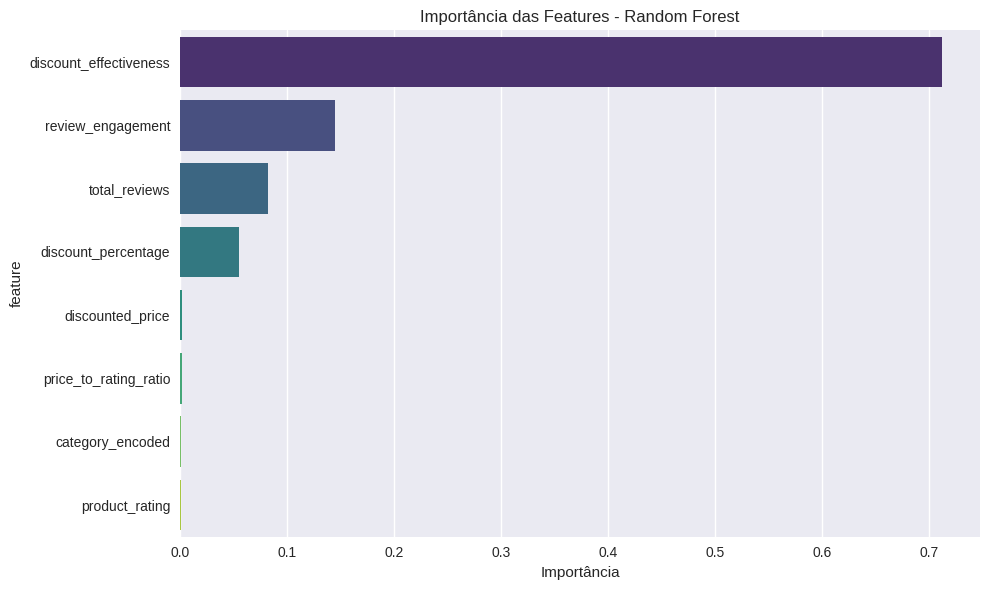

Top 5 features mais importantes:
                  feature  importance
6  discount_effectiveness    0.711719
5       review_engagement    0.144646
3           total_reviews    0.082661
1     discount_percentage    0.055628
0        discounted_price    0.001965


In [29]:
# 10. ANÁLISE DE IMPORTÂNCIA DAS FEATURES
print("=== IMPORTÂNCIA DAS FEATURES ===")

if best_model is not None and best_model_name is not None:
    if hasattr(best_model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
        plt.title(f'Importância das Features - {best_model_name}')
        plt.xlabel('Importância')
        plt.tight_layout()
        plt.show()

        print("Top 5 features mais importantes:")
        print(feature_importance.head())

    elif hasattr(best_model, 'coef_'):
        # Para modelos lineares, usar coeficientes absolutos
        coef_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': np.abs(best_model.coef_)
        }).sort_values('importance', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(data=coef_importance, x='importance', y='feature', palette='viridis')
        plt.title(f'Importância das Features (Coeficientes) - {best_model_name}')
        plt.xlabel('Importância (Valor Absoluto do Coeficiente)')
        plt.tight_layout()
        plt.show()

        print("Top 5 features mais importantes (coeficientes):")
        print(coef_importance.head())
    else:
        print(f"O modelo {best_model_name} não possui atributo de importância de features")
else:
    print("Nenhum modelo disponível para análise de importância de features")

=== CLUSTERIZAÇÃO DE PRODUTOS ===


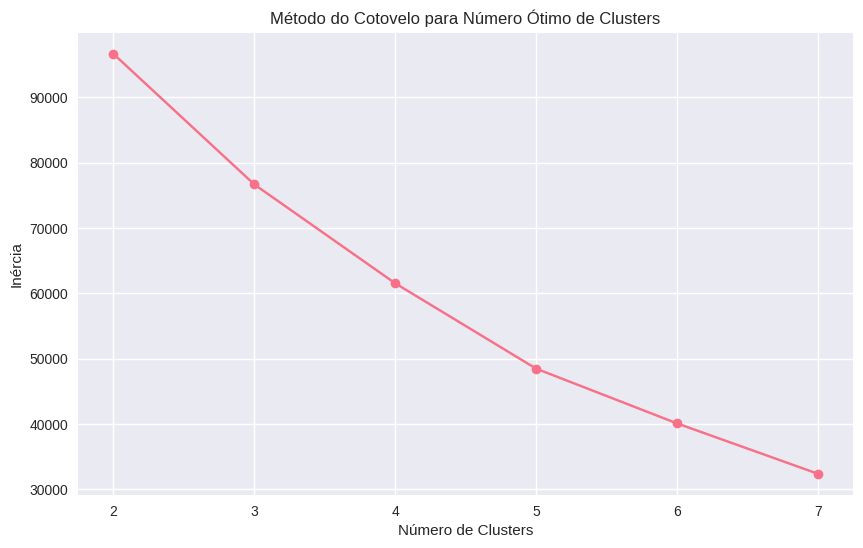


Características médias de cada cluster (2 clusters):
         discounted_price  product_rating  total_reviews  purchased_last_month
cluster                                                                       
0              157.298309        4.437141    3263.839594            996.245013
1               17.795946        4.770270   91838.500000          74181.756757


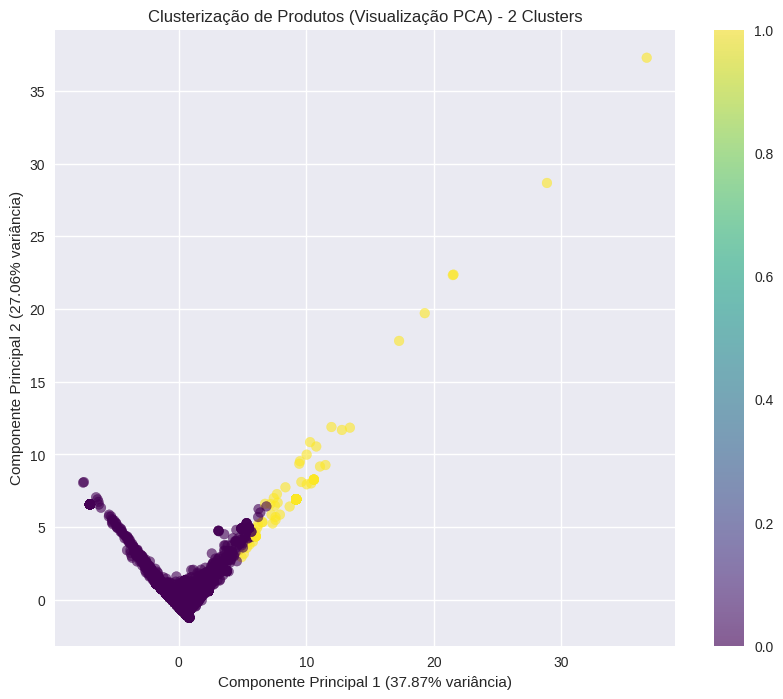

In [30]:
# 11. CLUSTERIZAÇÃO DE PRODUTOS
print("=== CLUSTERIZAÇÃO DE PRODUTOS ===")

# Features para clusterização
cluster_features = []
for col in ['discounted_price', 'product_rating', 'total_reviews', 'purchased_last_month']:
    if col in df_clean.columns:
        cluster_features.append(col)

if len(cluster_features) >= 2:  # Precisamos de pelo menos 2 features para clusterização
    cluster_df = df_clean[cluster_features].dropna()

    if len(cluster_df) > 10:  # Precisamos de dados suficientes
        # Normalizar dados
        scaler = StandardScaler()
        X_cluster = scaler.fit_transform(cluster_df)

        # Determinar número ótimo de clusters usando elbow method
        inertia = []
        possible_clusters = range(2, min(8, len(cluster_df)//10))  # Limitar baseado no tamanho dos dados

        for k in possible_clusters:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(X_cluster)
            inertia.append(kmeans.inertia_)

        plt.figure(figsize=(10, 6))
        plt.plot(possible_clusters, inertia, marker='o')
        plt.title('Método do Cotovelo para Número Ótimo de Clusters')
        plt.xlabel('Número de Clusters')
        plt.ylabel('Inércia')
        plt.show()

        # Aplicar K-means (usar 4 clusters por padrão ou baseado no cotovelo)
        optimal_clusters = 4
        if len(inertia) > 1:
            # Encontrar o "cotovelo" - ponto onde a diminuição da inércia desacelera
            differences = np.diff(inertia)
            if len(differences) > 0:
                # Encontrar onde a diferença começa a ficar pequena
                optimal_clusters = possible_clusters[np.argmax(differences < np.mean(differences))] if any(differences < np.mean(differences)) else 4

        kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(X_cluster)

        # Análise dos clusters
        cluster_df = cluster_df.copy()
        cluster_df['cluster'] = clusters

        cluster_analysis = cluster_df.groupby('cluster').mean()
        print(f"\nCaracterísticas médias de cada cluster ({optimal_clusters} clusters):")
        print(cluster_analysis)

        # Visualização dos clusters (usando PCA se tivermos mais de 2 dimensões)
        if X_cluster.shape[1] > 2:
            pca = PCA(n_components=2)
            X_pca = pca.fit_transform(X_cluster)

            plt.figure(figsize=(10, 8))
            scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
            plt.colorbar(scatter)
            plt.title(f'Clusterização de Produtos (Visualização PCA) - {optimal_clusters} Clusters')
            plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]:.2%} variância)')
            plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]:.2%} variância)')
            plt.show()
        else:
            plt.figure(figsize=(10, 8))
            scatter = plt.scatter(X_cluster[:, 0], X_cluster[:, 1], c=clusters, cmap='viridis', alpha=0.6)
            plt.colorbar(scatter)
            plt.title(f'Clusterização de Produtos - {optimal_clusters} Clusters')
            plt.xlabel(cluster_features[0])
            plt.ylabel(cluster_features[1])
            plt.show()

    else:
        print("Dados insuficientes para clusterização")
else:
    print(f"Features insuficientes para clusterização. Encontradas: {len(cluster_features)}")

=== ANÁLISE AVANÇADA DE CORRELAÇÕES ===


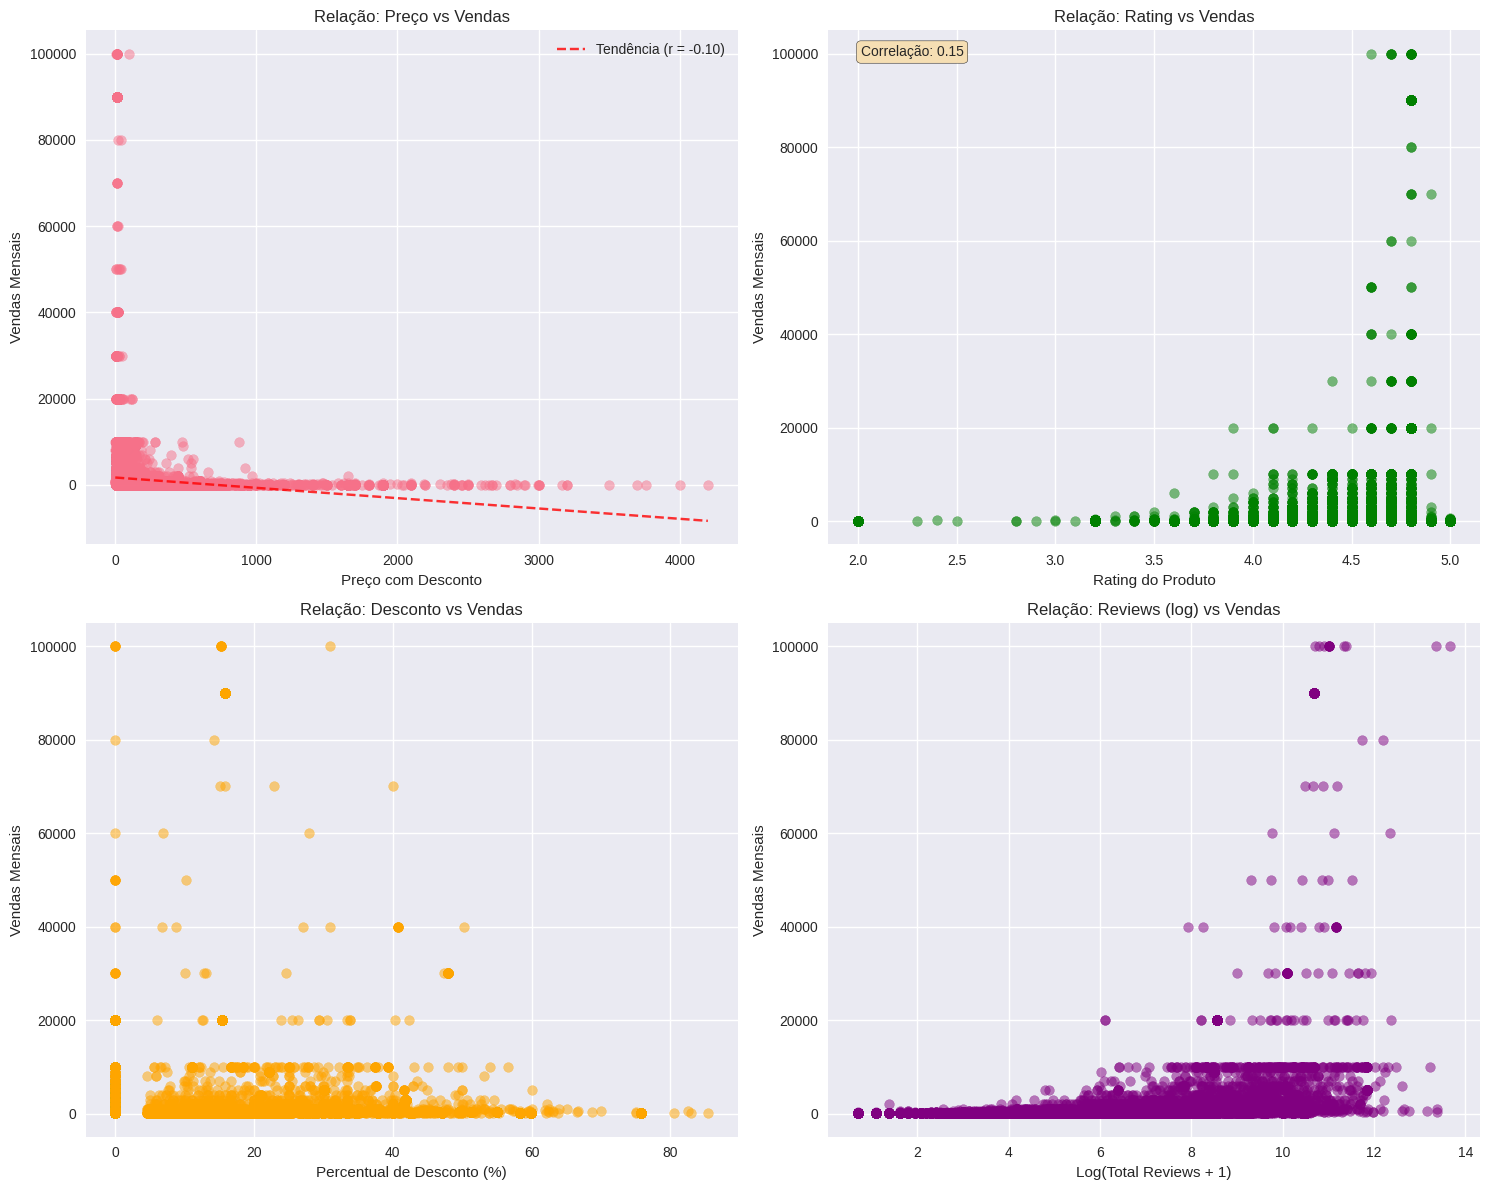


--- CORRELAÇÕES DETALHADAS ---
Correlação discounted_price vs Vendas: -0.096
Correlação discount_percentage vs Vendas: 0.043
Correlação product_rating vs Vendas: 0.152
Correlação total_reviews vs Vendas: 0.296

Variáveis mais relacionadas com Vendas (absoluto):
  total_reviews: 0.296 (MODERADA POSITIVA)
  product_rating: 0.152 (MODERADA POSITIVA)
  discounted_price: -0.096 (FRACA NEGATIVA)
  discount_percentage: 0.043 (FRACA POSITIVA)


In [32]:
# 12. ANÁLISE AVANÇADA DE CORRELAÇÕES E SEGMENTAÇÃO (VERSÃO CORRIGIDA)
print("=== ANÁLISE AVANÇADA DE CORRELAÇÕES ===")

# Vamos explorar correlações de forma mais detalhada e segura
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Preço vs Vendas - CORRIGIDO
if 'discounted_price' in df_clean.columns and 'purchased_last_month' in df_clean.columns:
    # Garantir que temos dados válidos para ambas as colunas
    temp_df = df_clean[['discounted_price', 'purchased_last_month']].dropna()
    if len(temp_df) > 0:
        axes[0,0].scatter(temp_df['discounted_price'], temp_df['purchased_last_month'], alpha=0.5)
        axes[0,0].set_title('Relação: Preço vs Vendas')
        axes[0,0].set_xlabel('Preço com Desconto')
        axes[0,0].set_ylabel('Vendas Mensais')
        # Adicionar linha de tendência de forma segura
        if len(temp_df) > 1:
            z = np.polyfit(temp_df['discounted_price'], temp_df['purchased_last_month'], 1)
            p = np.poly1d(z)
            x_range = np.linspace(temp_df['discounted_price'].min(), temp_df['discounted_price'].max(), 100)
            axes[0,0].plot(x_range, p(x_range), "r--", alpha=0.8, label=f'Tendência (r = {temp_df["discounted_price"].corr(temp_df["purchased_last_month"]):.2f})')
            axes[0,0].legend()

# Rating vs Vendas - CORRIGIDO
if 'product_rating' in df_clean.columns and 'purchased_last_month' in df_clean.columns:
    temp_df = df_clean[['product_rating', 'purchased_last_month']].dropna()
    if len(temp_df) > 0:
        axes[0,1].scatter(temp_df['product_rating'], temp_df['purchased_last_month'], alpha=0.5, color='green')
        axes[0,1].set_title('Relação: Rating vs Vendas')
        axes[0,1].set_xlabel('Rating do Produto')
        axes[0,1].set_ylabel('Vendas Mensais')
        if len(temp_df) > 1:
            correlation = temp_df['product_rating'].corr(temp_df['purchased_last_month'])
            axes[0,1].text(0.05, 0.95, f'Correlação: {correlation:.2f}',
                          transform=axes[0,1].transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))

# Desconto vs Vendas - CORRIGIDO
if 'discount_percentage' in df_clean.columns and 'purchased_last_month' in df_clean.columns:
    temp_df = df_clean[['discount_percentage', 'purchased_last_month']].dropna()
    if len(temp_df) > 0:
        axes[1,0].scatter(temp_df['discount_percentage'], temp_df['purchased_last_month'], alpha=0.5, color='orange')
        axes[1,0].set_title('Relação: Desconto vs Vendas')
        axes[1,0].set_xlabel('Percentual de Desconto (%)')
        axes[1,0].set_ylabel('Vendas Mensais')

# Reviews vs Vendas - CORRIGIDO
if 'total_reviews' in df_clean.columns and 'purchased_last_month' in df_clean.columns:
    temp_df = df_clean[['total_reviews', 'purchased_last_month']].dropna()
    if len(temp_df) > 0:
        # Usar log para melhor visualização
        temp_df['log_reviews'] = np.log1p(temp_df['total_reviews'])
        axes[1,1].scatter(temp_df['log_reviews'], temp_df['purchased_last_month'], alpha=0.5, color='purple')
        axes[1,1].set_title('Relação: Reviews (log) vs Vendas')
        axes[1,1].set_xlabel('Log(Total Reviews + 1)')
        axes[1,1].set_ylabel('Vendas Mensais')

plt.tight_layout()
plt.show()

# Análise de correlações com tratamento de missing values
print("\n--- CORRELAÇÕES DETALHADAS ---")
correlation_analysis = {}

for col1 in ['discounted_price', 'actual_price', 'discount_percentage', 'product_rating', 'total_reviews']:
    if col1 in df_clean.columns and 'purchased_last_month' in df_clean.columns:
        temp_df = df_clean[[col1, 'purchased_last_month']].dropna()
        if len(temp_df) > 1:
            corr = temp_df[col1].corr(temp_df['purchased_last_month'])
            correlation_analysis[col1] = corr
            print(f"Correlação {col1} vs Vendas: {corr:.3f}")

# Ordenar por correlação absoluta
if correlation_analysis:
    print("\nVariáveis mais relacionadas com Vendas (absoluto):")
    for var, corr in sorted(correlation_analysis.items(), key=lambda x: abs(x[1]), reverse=True):
        strength = "FORTE" if abs(corr) > 0.3 else "MODERADA" if abs(corr) > 0.1 else "FRACA"
        direction = "POSITIVA" if corr > 0 else "NEGATIVA"
        print(f"  {var}: {corr:.3f} ({strength} {direction})")

=== ANÁLISE DETALHADA POR CATEGORIA ===


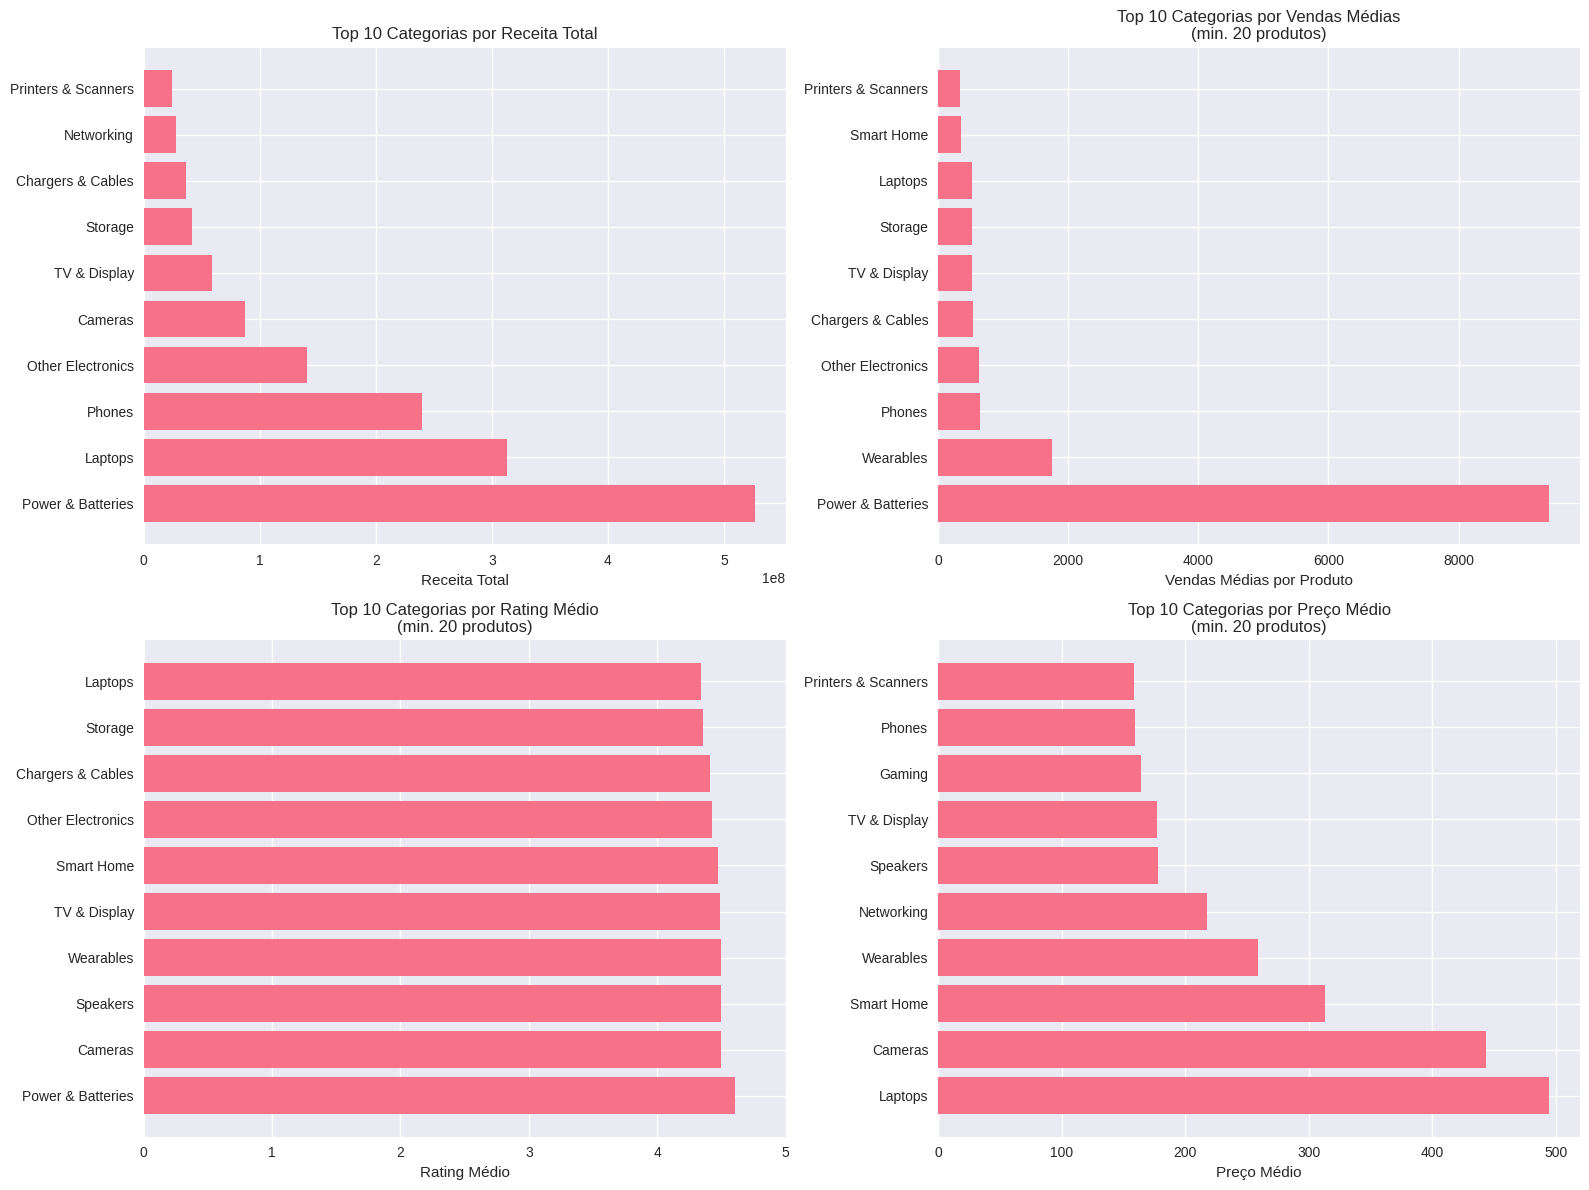

Estatísticas das Top 5 Categorias por Receita:
                   revenue_sum  purchased_last_month_sum  \
product_category                                           
Power & Batteries  526680775.0                26151450.0   
Laptops            313388067.0                 3416450.0   
Phones             240152064.0                 3729550.0   
Other Electronics  140987195.0                 3425800.0   
Cameras             86995724.5                  835300.0   

                   purchased_last_month_mean  purchased_last_month_count  \
product_category                                                           
Power & Batteries                    9396.86                        2783   
Laptops                               514.99                        6634   
Phones                                642.36                        5806   
Other Electronics                     631.48                        5425   
Cameras                               321.39                        2599   


In [34]:
# 13. ANÁLISE DE CATEGORIAS MAIS DETALHADA (VERSÃO MELHORADA)
print("=== ANÁLISE DETALHADA POR CATEGORIA ===")

if 'product_category' in df_clean.columns:
    # Garantir que temos revenue calculado
    if 'revenue' not in df_clean.columns:
        df_clean['revenue'] = df_clean['discounted_price'] * df_clean['purchased_last_month']

    # Top categorias por diferentes métricas
    category_metrics = df_clean.groupby('product_category').agg({
        'revenue': 'sum',
        'purchased_last_month': ['sum', 'mean', 'count'],
        'product_rating': 'mean',
        'discounted_price': 'mean',
        'discount_percentage': 'mean'
    }).round(2)

    # Simplificar nomes das colunas
    category_metrics.columns = ['_'.join(col).strip() for col in category_metrics.columns.values]

    # Top 10 por receita
    top_revenue_categories = category_metrics.nlargest(10, 'revenue_sum')

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Receita por categoria
    axes[0,0].barh(range(len(top_revenue_categories)), top_revenue_categories['revenue_sum'])
    axes[0,0].set_yticks(range(len(top_revenue_categories)))
    axes[0,0].set_yticklabels(top_revenue_categories.index)
    axes[0,0].set_title('Top 10 Categorias por Receita Total')
    axes[0,0].set_xlabel('Receita Total')

    # 2. Vendas médias por categoria (apenas categorias com bom volume)
    significant_categories = category_metrics[category_metrics['purchased_last_month_count'] >= 20]
    top_avg_sales = significant_categories.nlargest(10, 'purchased_last_month_mean')

    if not top_avg_sales.empty:
        axes[0,1].barh(range(len(top_avg_sales)), top_avg_sales['purchased_last_month_mean'])
        axes[0,1].set_yticks(range(len(top_avg_sales)))
        axes[0,1].set_yticklabels(top_avg_sales.index)
        axes[0,1].set_title('Top 10 Categorias por Vendas Médias\n(min. 20 produtos)')
        axes[0,1].set_xlabel('Vendas Médias por Produto')

    # 3. Rating médio por categoria
    top_rated_categories = significant_categories.nlargest(10, 'product_rating_mean')

    if not top_rated_categories.empty:
        axes[1,0].barh(range(len(top_rated_categories)), top_rated_categories['product_rating_mean'])
        axes[1,0].set_yticks(range(len(top_rated_categories)))
        axes[1,0].set_yticklabels(top_rated_categories.index)
        axes[1,0].set_title('Top 10 Categorias por Rating Médio\n(min. 20 produtos)')
        axes[1,0].set_xlabel('Rating Médio')
        axes[1,0].set_xlim(0, 5)  # Ratings vão de 0 a 5

    # 4. Preço médio por categoria
    top_price_categories = significant_categories.nlargest(10, 'discounted_price_mean')

    if not top_price_categories.empty:
        axes[1,1].barh(range(len(top_price_categories)), top_price_categories['discounted_price_mean'])
        axes[1,1].set_yticks(range(len(top_price_categories)))
        axes[1,1].set_yticklabels(top_price_categories.index)
        axes[1,1].set_title('Top 10 Categorias por Preço Médio\n(min. 20 produtos)')
        axes[1,1].set_xlabel('Preço Médio')

    plt.tight_layout()
    plt.show()

    print("Estatísticas das Top 5 Categorias por Receita:")
    print(top_revenue_categories.head())

    # Análise de oportunidades
    print("\n--- OPORTUNIDADES IDENTIFICADAS ---")

    # Categorias com alta demanda mas baixa satisfação
    high_demand = category_metrics[category_metrics['purchased_last_month_sum'] > category_metrics['purchased_last_month_sum'].median()]
    low_rating = high_demand[high_demand['product_rating_mean'] < high_demand['product_rating_mean'].median()]

    if not low_rating.empty:
        print(" Categorias com Alta Demanda mas Baixa Satisfação:")
        for category in low_rating.index[:3]:
            rating = low_rating.loc[category, 'product_rating_mean']
            sales = low_rating.loc[category, 'purchased_last_month_sum']
            print(f"  {category}: Rating {rating:.1f}, Vendas {sales:.0f}")

    # Categorias com alta satisfação mas baixa visibilidade
    high_rating = category_metrics[category_metrics['product_rating_mean'] > category_metrics['product_rating_mean'].quantile(0.75)]
    low_sales = high_rating[high_rating['purchased_last_month_sum'] < high_rating['purchased_last_month_sum'].median()]

    if not low_sales.empty:
        print("\n Categorias com Alta Qualidade mas Baixa Venda:")
        for category in low_sales.index[:3]:
            rating = low_sales.loc[category, 'product_rating_mean']
            sales = low_sales.loc[category, 'purchased_last_month_sum']
            print(f"   {category}: Rating {rating:.1f}, Vendas {sales:.0f}")

=== ANÁLISE DE ESTRATÉGIA DE PREÇOS ===
Estatísticas de Preço:
  Mínimo: $2.16
  Médio: $243.23
  Mediana: $84.99
  Máximo: $5449.00

Análise por Faixa de Preço:
            purchased_last_month                      product_rating  \
                           count     mean         sum           mean   
price_range                                                            
$0-30                       8832  3794.40  33512100.0           4.55   
$30-85                      7497   495.30   3713250.0           4.36   
$85-224                     8258   354.36   2926300.0           4.38   
$224+                       5717   139.73    798850.0           4.34   

            discount_percentage      revenue  
                           mean          sum  
price_range                                   
$0-30                     10.03  630727405.5  
$30-85                     8.74  184569402.5  
$85-224                    3.59  390159126.5  
$224+                      3.81  370446958.5  


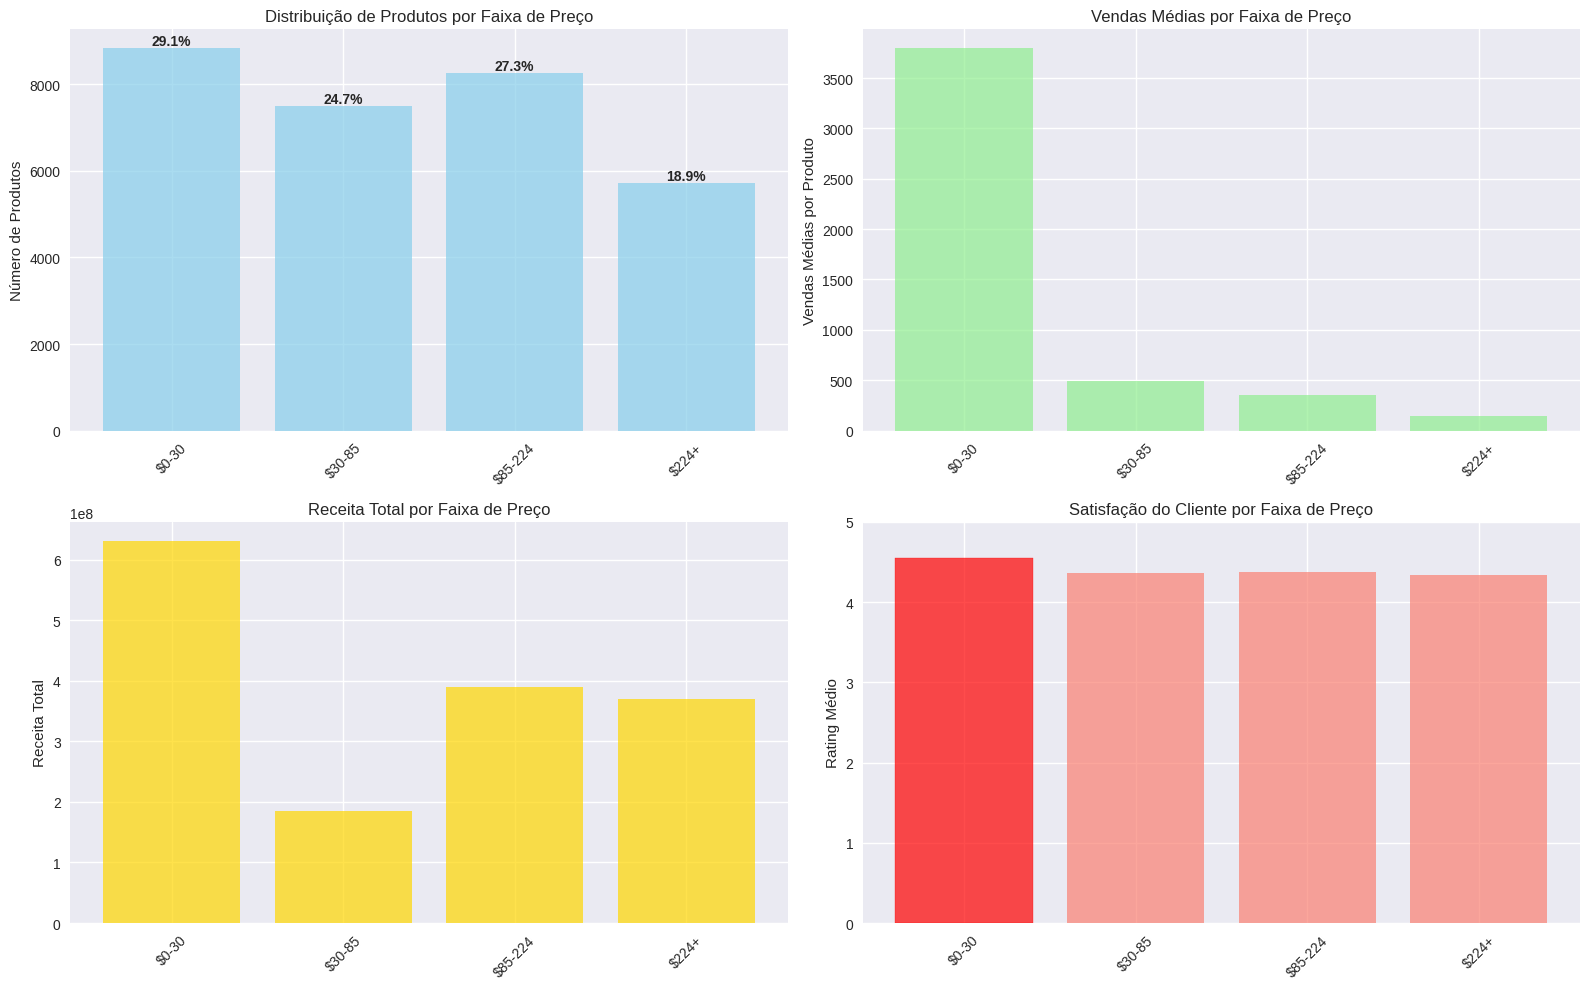


 INSIGHTS SOBRE ESTRATÉGIA DE PREÇOS:
  Melhor performance: $0-30 (vendas médias: 3794.4)
   Maior receita: $0-30 (receita: $630,727,406)
   Melhor satisfação: $0-30 (rating: 4.5/5)


In [36]:
# 14. ANÁLISE DE PREÇOS E ESTRATÉGIAS DE DESCONTO (VERSÃO APRIMORADA)
print("=== ANÁLISE DE ESTRATÉGIA DE PREÇOS ===")

if 'discounted_price' in df_clean.columns:
    # Criar faixas de preço mais inteligentes
    price_stats = df_clean['discounted_price'].describe()
    print(f"Estatísticas de Preço:")
    print(f"  Mínimo: ${price_stats['min']:.2f}")
    print(f"  Médio: ${price_stats['mean']:.2f}")
    print(f"  Mediana: ${price_stats['50%']:.2f}")
    print(f"  Máximo: ${price_stats['max']:.2f}")

    # Usar quartis para criar faixas mais balanceadas
    price_quartiles = df_clean['discounted_price'].quantile([0, 0.25, 0.5, 0.75, 1]).values
    price_bins = [0] + list(price_quartiles[1:-1]) + [float('inf')]
    price_labels = [f'${price_bins[i]:.0f}-{price_bins[i+1]:.0f}' for i in range(len(price_bins)-2)] + [f'${price_bins[-2]:.0f}+']

    df_clean['price_range'] = pd.cut(df_clean['discounted_price'], bins=price_bins, labels=price_labels)

    # Análise detalhada por faixa de preço
    price_analysis = df_clean.groupby('price_range').agg({
        'purchased_last_month': ['count', 'mean', 'sum'],
        'product_rating': 'mean',
        'discount_percentage': 'mean',
        'revenue': 'sum'
    }).round(2)

    print("\nAnálise por Faixa de Preço:")
    print(price_analysis)

    # Visualização aprimorada
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # 1. Quantidade de produtos por faixa de preço
    price_counts = price_analysis[('purchased_last_month', 'count')]
    axes[0,0].bar(price_counts.index, price_counts.values, color='skyblue', alpha=0.7)
    axes[0,0].set_title('Distribuição de Produtos por Faixa de Preço')
    axes[0,0].set_ylabel('Número de Produtos')
    axes[0,0].tick_params(axis='x', rotation=45)

    # Adicionar porcentagens
    total_products = price_counts.sum()
    for i, v in enumerate(price_counts.values):
        axes[0,0].text(i, v, f'{v/total_products*100:.1f}%',
                      ha='center', va='bottom', fontweight='bold')

    # 2. Vendas médias por faixa de preço
    avg_sales = price_analysis[('purchased_last_month', 'mean')]
    axes[0,1].bar(avg_sales.index, avg_sales.values, color='lightgreen', alpha=0.7)
    axes[0,1].set_title('Vendas Médias por Faixa de Preço')
    axes[0,1].set_ylabel('Vendas Médias por Produto')
    axes[0,1].tick_params(axis='x', rotation=45)

    # 3. Receita total por faixa de preço
    total_revenue = price_analysis[('revenue', 'sum')]
    axes[1,0].bar(total_revenue.index, total_revenue.values, color='gold', alpha=0.7)
    axes[1,0].set_title('Receita Total por Faixa de Preço')
    axes[1,0].set_ylabel('Receita Total')
    axes[1,0].tick_params(axis='x', rotation=45)

    # 4. Rating médio por faixa de preço
    avg_rating = price_analysis[('product_rating', 'mean')]
    bars = axes[1,1].bar(avg_rating.index, avg_rating.values, color='salmon', alpha=0.7)
    axes[1,1].set_title('Satisfação do Cliente por Faixa de Preço')
    axes[1,1].set_ylabel('Rating Médio')
    axes[1,1].set_ylim(0, 5)
    axes[1,1].tick_params(axis='x', rotation=45)

    # Destacar a faixa com melhor rating
    best_rating_idx = avg_rating.idxmax()
    best_rating_bar = [bar for bar, label in zip(bars, avg_rating.index) if label == best_rating_idx][0]
    best_rating_bar.set_color('red')

    plt.tight_layout()
    plt.show()

    # Insights sobre preços
    print("\n INSIGHTS SOBRE ESTRATÉGIA DE PREÇOS:")

    # Faixa com melhor performance (vendas médias)
    best_sales_range = avg_sales.idxmax()
    best_sales_value = avg_sales.max()
    print(f"  Melhor performance: {best_sales_range} (vendas médias: {best_sales_value:.1f})")

    # Faixa com maior receita
    best_revenue_range = total_revenue.idxmax()
    best_revenue_value = total_revenue.max()
    print(f"   Maior receita: {best_revenue_range} (receita: ${best_revenue_value:,.0f})")

    # Faixa com melhor satisfação
    best_rating_range = avg_rating.idxmax()
    best_rating_value = avg_rating.max()
    print(f"   Melhor satisfação: {best_rating_range} (rating: {best_rating_value:.1f}/5)")

=== ANÁLISE DE DESEMPENHO POR SATISFAÇÃO ===
Análise Detalhada por Rating:
               purchased_last_month                      discounted_price  \
                              count     mean         sum             mean   
product_rating                                                              
1.0                               0      NaN         0.0           228.01   
1.5                               0      NaN         0.0          1250.24   
2.0                             142    50.00      7100.0          1887.05   
2.3                               1    50.00        50.0           339.99   
2.4                               1   200.00       200.0           518.32   
2.5                               1    50.00        50.0           519.99   
2.6                               0      NaN         0.0           119.99   
2.7                               0      NaN         0.0           221.67   
2.8                               2   100.00       200.0           414.74   
2

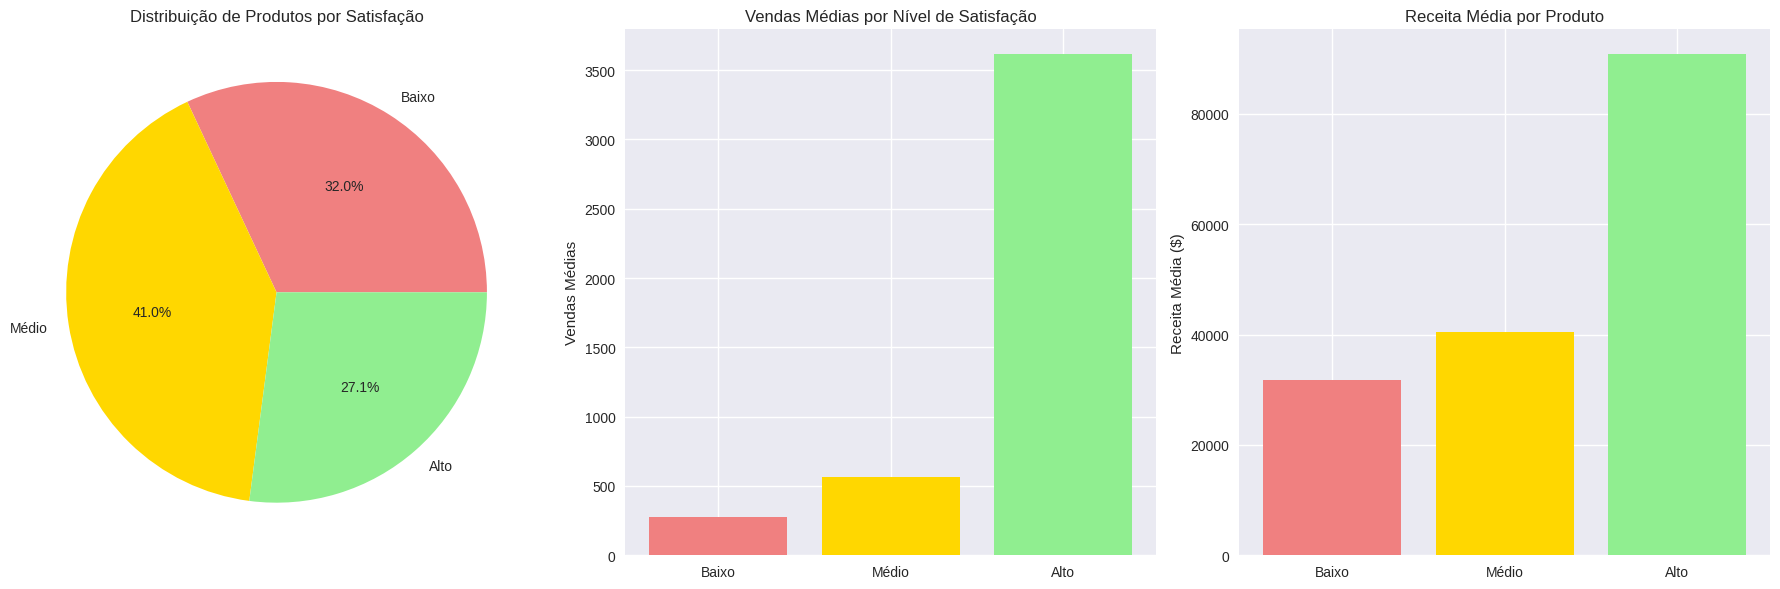


 INSIGHTS SOBRE SATISFAÇÃO DO CLIENTE:
  Produtos com alta satisfação vendem 1212% mais que produtos com baixa satisfação
  OPORTUNIDADE: Melhorar a satisfação pode dobrar as vendas!


In [37]:
# 15. ANÁLISE DE DESEMPENHO POR RATING (VERSÃO EXPANDIDA)
print("=== ANÁLISE DE DESEMPENHO POR SATISFAÇÃO ===")

if 'product_rating' in df_clean.columns:
    # Análise mais granular de ratings
    rating_analysis = df_clean.groupby('product_rating').agg({
        'purchased_last_month': ['count', 'mean', 'sum'],
        'discounted_price': 'mean',
        'total_reviews': 'mean',
        'revenue': 'sum'
    }).round(2)

    print("Análise Detalhada por Rating:")
    print(rating_analysis)

    # Criar categorias de rating baseadas nos dados
    rating_percentiles = df_clean['product_rating'].quantile([0.33, 0.66]).values
    rating_bins = [0, rating_percentiles[0], rating_percentiles[1], 5]
    rating_labels = ['Baixo', 'Médio', 'Alto']

    df_clean['rating_category'] = pd.cut(df_clean['product_rating'], bins=rating_bins, labels=rating_labels)

    category_analysis = df_clean.groupby('rating_category').agg({
        'purchased_last_month': ['count', 'mean', 'sum'],
        'discounted_price': 'mean',
        'total_reviews': 'mean',
        'revenue': ['sum', 'mean']
    }).round(2)

    print(f"\n Análise por Categoria de Rating (limites: {rating_bins})")
    print(category_analysis)

    # Visualização
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Distribuição de produtos por categoria de rating
    rating_dist = category_analysis[('purchased_last_month', 'count')]
    axes[0].pie(rating_dist.values, labels=rating_dist.index, autopct='%1.1f%%',
                colors=['lightcoral', 'gold', 'lightgreen'])
    axes[0].set_title('Distribuição de Produtos por Satisfação')

    # 2. Vendas médias por categoria
    sales_by_rating = category_analysis[('purchased_last_month', 'mean')]
    bars = axes[1].bar(sales_by_rating.index, sales_by_rating.values,
                      color=['lightcoral', 'gold', 'lightgreen'])
    axes[1].set_title('Vendas Médias por Nível de Satisfação')
    axes[1].set_ylabel('Vendas Médias')

    # 3. Receita média por produto
    revenue_by_rating = category_analysis[('revenue', 'mean')]
    axes[2].bar(revenue_by_rating.index, revenue_by_rating.values,
               color=['lightcoral', 'gold', 'lightgreen'])
    axes[2].set_title('Receita Média por Produto')
    axes[2].set_ylabel('Receita Média ($)')

    plt.tight_layout()
    plt.show()

    # Insights sobre satisfação
    print("\n INSIGHTS SOBRE SATISFAÇÃO DO CLIENTE:")

    high_rating_perf = category_analysis.loc['Alto', ('purchased_last_month', 'mean')]
    low_rating_perf = category_analysis.loc['Baixo', ('purchased_last_month', 'mean')]

    improvement_potential = ((high_rating_perf - low_rating_perf) / low_rating_perf) * 100
    print(f"  Produtos com alta satisfação vendem {improvement_potential:.0f}% mais que produtos com baixa satisfação")

    if improvement_potential > 50:
        print("  OPORTUNIDADE: Melhorar a satisfação pode dobrar as vendas!")
    elif improvement_potential > 20:
        print("  OPORTUNIDADE: Ganhos significativos ao melhorar a satisfação")

In [39]:
# 16. ANÁLISE DE PRODUTOS MAIS VENDIDOS E RECOMENDAÇÕES (VERSÃO PRÁTICA)
print("=== ANÁLISE DE PRODUTOS COM MELHOR DESEMPENHO ===")

# Garantir que temos revenue calculado
if 'revenue' not in df_clean.columns:
    df_clean['revenue'] = df_clean['discounted_price'] * df_clean['purchased_last_month']

# Identificar produtos com melhor desempenho em diferentes métricas
performance_metrics = {}

# 1. Produtos mais vendidos (volume)
top_selling = df_clean.nlargest(5, 'purchased_last_month')[['product_category', 'discounted_price', 'product_rating', 'purchased_last_month', 'revenue']]
performance_metrics['Mais Vendidos'] = top_selling

# 2. Produtos com maior receita
top_revenue = df_clean.nlargest(5, 'revenue')[['product_category', 'discounted_price', 'product_rating', 'purchased_last_month', 'revenue']]
performance_metrics['Maior Receita'] = top_revenue

# 3. Produtos com melhor custo-benefício
if 'product_rating' in df_clean.columns and 'discounted_price' in df_clean.columns:
    df_clean['value_score'] = (df_clean['product_rating'] * df_clean['purchased_last_month']) / (df_clean['discounted_price'] + 1)
    best_value = df_clean.nlargest(5, 'value_score')[['product_category', 'discounted_price', 'product_rating', 'purchased_last_month', 'value_score']]
    performance_metrics['Melhor Custo-Benefício'] = best_value

# 4. Produtos com alta satisfação e boa venda
high_rating_high_sales = df_clean[
    (df_clean['product_rating'] >= 4) &
    (df_clean['purchased_last_month'] > df_clean['purchased_last_month'].median())
].nlargest(5, 'purchased_last_month')[['product_category', 'discounted_price', 'product_rating', 'purchased_last_month']]
performance_metrics['Alta Qualidade + Vendas'] = high_rating_high_sales

# Mostrar resultados
for metric, products in performance_metrics.items():
    print(f"\n {metric}:")
    print(products.to_string(index=False))

# Análise de padrões nos produtos de sucesso
print("\n PADRÕES NOS PRODUTOS DE SUCESSO:")

success_patterns = {}

# Preço médio dos produtos mais vendidos
if not top_selling.empty:
    avg_price_top = top_selling['discounted_price'].mean()
    avg_price_all = df_clean['discounted_price'].mean()
    success_patterns['Preço Médio'] = f"Top: ${avg_price_top:.2f} vs Geral: ${avg_price_all:.2f}"

# Rating médio dos produtos mais vendidos
if not top_selling.empty and 'product_rating' in top_selling.columns:
    avg_rating_top = top_selling['product_rating'].mean()
    avg_rating_all = df_clean['product_rating'].mean()
    success_patterns['Rating Médio'] = f"Top: {avg_rating_top:.1f} vs Geral: {avg_rating_all:.1f}"

for pattern, value in success_patterns.items():
    print(f"   {pattern}: {value}")


=== ANÁLISE DE PRODUTOS COM MELHOR DESEMPENHO ===

 Mais Vendidos:
 product_category  discounted_price  product_rating  purchased_last_month   revenue
Other Electronics             99.95             4.6              100000.0 9995000.0
          Laptops             14.99             4.7              100000.0 1499000.0
Other Electronics             17.45             4.7              100000.0 1745000.0
          Laptops             14.49             4.7              100000.0 1449000.0
Other Electronics             16.98             4.8              100000.0 1698000.0

 Maior Receita:
 product_category  discounted_price  product_rating  purchased_last_month   revenue
Other Electronics             99.95             4.6              100000.0 9995000.0
          Laptops            880.95             4.8               10000.0 8809500.0
          Laptops            476.50             4.8               10000.0 4765000.0
Other Electronics            485.05             4.5                9000.0 43

=== ANÁLISE DE SEGMENTAÇÃO MULTIDIMENSIONAL ===


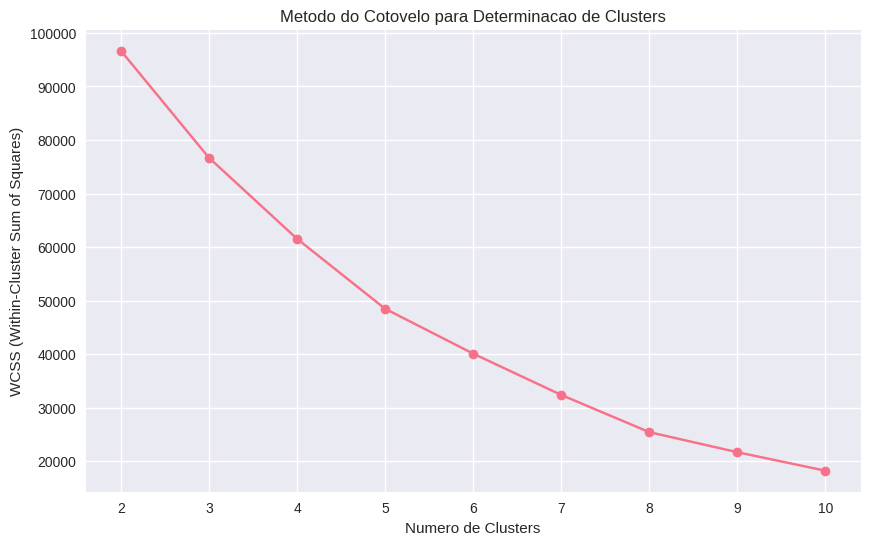

Analise Detalhada dos Segmentos:
        discounted_price         product_rating       purchased_last_month  \
                    mean     std           mean   std                 mean   
segment                                                                      
0                 129.35   93.42           4.31  0.12               431.29   
1                  16.23    8.47           4.80  0.03             89454.55   
2                 599.08  208.50           4.49  0.21               132.73   
3                1910.83  401.44           3.29  1.15                69.05   
4                  30.29   31.25           4.56  0.19              7448.54   
5                  66.00   69.50           4.67  0.12               515.20   
6                  24.53   13.98           4.78  0.08             19686.03   
7                 141.99  114.42           3.80  0.22               190.87   
8                  16.03   12.26           4.70  0.00             35316.67   

                    total_revi

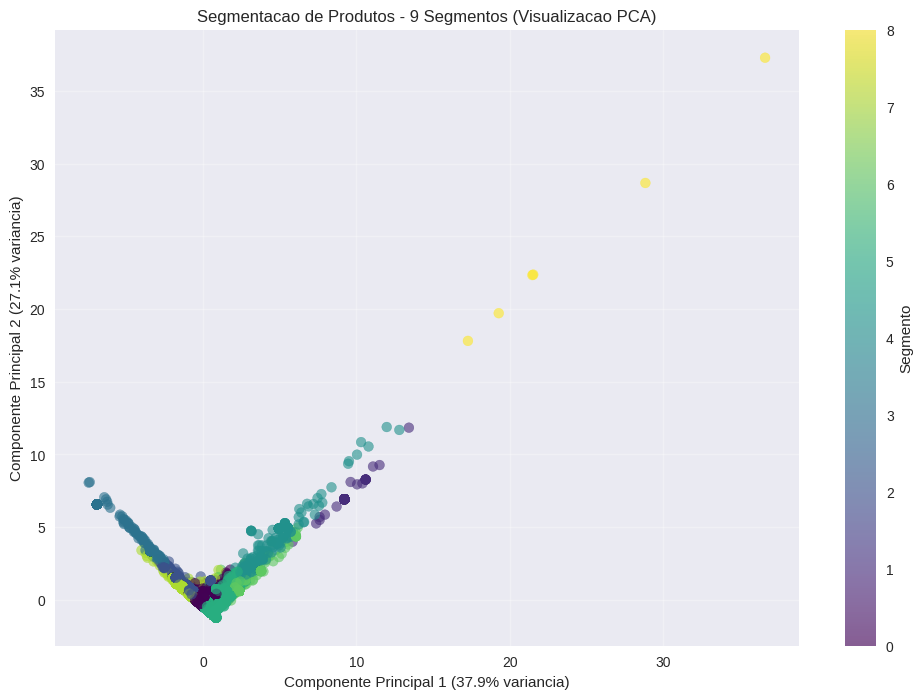


CARACTERIZACAO DOS SEGMENTOS:

Segmento 0:
  Numero de produtos: 8609
  Preco medio: $129.35
  Rating medio: 4.31
  Vendas medias: 431.29
  Receita total: $319949686.00

Segmento 1:
  Numero de produtos: 110
  Preco medio: $16.23
  Rating medio: 4.80
  Vendas medias: 89454.55
  Receita total: $160478500.00

Segmento 2:
  Numero de produtos: 2586
  Preco medio: $599.08
  Rating medio: 4.49
  Vendas medias: 132.73
  Receita total: $201295451.50

Segmento 3:
  Numero de produtos: 328
  Preco medio: $1910.83
  Rating medio: 3.29
  Vendas medias: 69.05
  Receita total: $43873207.00

Segmento 4:
  Numero de produtos: 171
  Preco medio: $30.29
  Rating medio: 4.56
  Vendas medias: 7448.54
  Receita total: $32550755.00

Segmento 5:
  Numero de produtos: 14115
  Preco medio: $66.00
  Rating medio: 4.67
  Vendas medias: 515.20
  Receita total: $324017170.00

Segmento 6:
  Numero de produtos: 895
  Preco medio: $24.53
  Rating medio: 4.78
  Vendas medias: 19686.03
  Receita total: $416336590.00


In [40]:
# 17. ANÁLISE DE SEGMENTAÇÃO AVANÇADA COM MÚLTIPLAS DIMENSÕES
print("=== ANÁLISE DE SEGMENTAÇÃO MULTIDIMENSIONAL ===")

# Criar segmentos baseados em múltiplas características
if all(col in df_clean.columns for col in ['discounted_price', 'product_rating', 'purchased_last_month']):

    # Preparar dados para segmentação
    segmentation_data = df_clean[['discounted_price', 'product_rating', 'purchased_last_month', 'total_reviews']].dropna()

    if len(segmentation_data) > 100:  # Garantir dados suficientes
        # Normalizar os dados
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(segmentation_data)

        # Determinar número ideal de clusters
        wcss = []
        max_clusters = min(10, len(segmentation_data)//20)

        for i in range(2, max_clusters + 1):
            kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
            kmeans.fit(scaled_data)
            wcss.append(kmeans.inertia_)

        # Plot do método do cotovelo
        plt.figure(figsize=(10, 6))
        plt.plot(range(2, max_clusters + 1), wcss, marker='o')
        plt.title('Metodo do Cotovelo para Determinacao de Clusters')
        plt.xlabel('Numero de Clusters')
        plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
        plt.grid(True)
        plt.show()

        # Aplicar K-means com numero otimo (usando diferenca das diferencas)
        diffs = np.diff(wcss)
        diff_ratios = diffs[1:] / diffs[:-1] if len(diffs) > 1 else [1]
        optimal_clusters = np.argmax(diff_ratios) + 3 if len(diff_ratios) > 0 else 4

        kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
        segments = kmeans.fit_predict(scaled_data)

        # Adicionar segmentos ao dataframe
        segmentation_data = segmentation_data.copy()
        segmentation_data['segment'] = segments

        # Analise detalhada dos segmentos
        segment_analysis = segmentation_data.groupby('segment').agg({
            'discounted_price': ['mean', 'std'],
            'product_rating': ['mean', 'std'],
            'purchased_last_month': ['mean', 'sum'],
            'total_reviews': 'mean'
        }).round(2)

        print("Analise Detalhada dos Segmentos:")
        print(segment_analysis)

        # Visualizacao dos segmentos com PCA
        pca = PCA(n_components=2)
        principal_components = pca.fit_transform(scaled_data)

        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1],
                            c=segments, cmap='viridis', alpha=0.6, s=50)
        plt.colorbar(scatter, label='Segmento')
        plt.title(f'Segmentacao de Produtos - {optimal_clusters} Segmentos (Visualizacao PCA)')
        plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]:.1%} variancia)')
        plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]:.1%} variancia)')
        plt.grid(True, alpha=0.3)
        plt.show()

        # Caracterizacao dos segmentos
        print("\nCARACTERIZACAO DOS SEGMENTOS:")
        for segment in range(optimal_clusters):
            segment_data = segmentation_data[segmentation_data['segment'] == segment]
            print(f"\nSegmento {segment}:")
            print(f"  Numero de produtos: {len(segment_data)}")
            print(f"  Preco medio: ${segment_data['discounted_price'].mean():.2f}")
            print(f"  Rating medio: {segment_data['product_rating'].mean():.2f}")
            print(f"  Vendas medias: {segment_data['purchased_last_month'].mean():.2f}")
            print(f"  Receita total: ${(segment_data['discounted_price'] * segment_data['purchased_last_month']).sum():.2f}")

=== ANALISE DE REGRESSAO MULTIVARIADA ===
Resultados da Regressao Linear Multivariada:
R-quadrado: 0.4241
Erro Quadratico Medio: 1.0825
Raiz do Erro Quadratico Medio: 1.0405

Coeficientes da Regressao:
              Variavel  Coeficiente  Importancia_Absoluta
1       product_rating     1.311979              1.311979
0     discounted_price    -0.460924              0.460924
2        total_reviews     0.222178              0.222178
3  discount_percentage     0.023391              0.023391


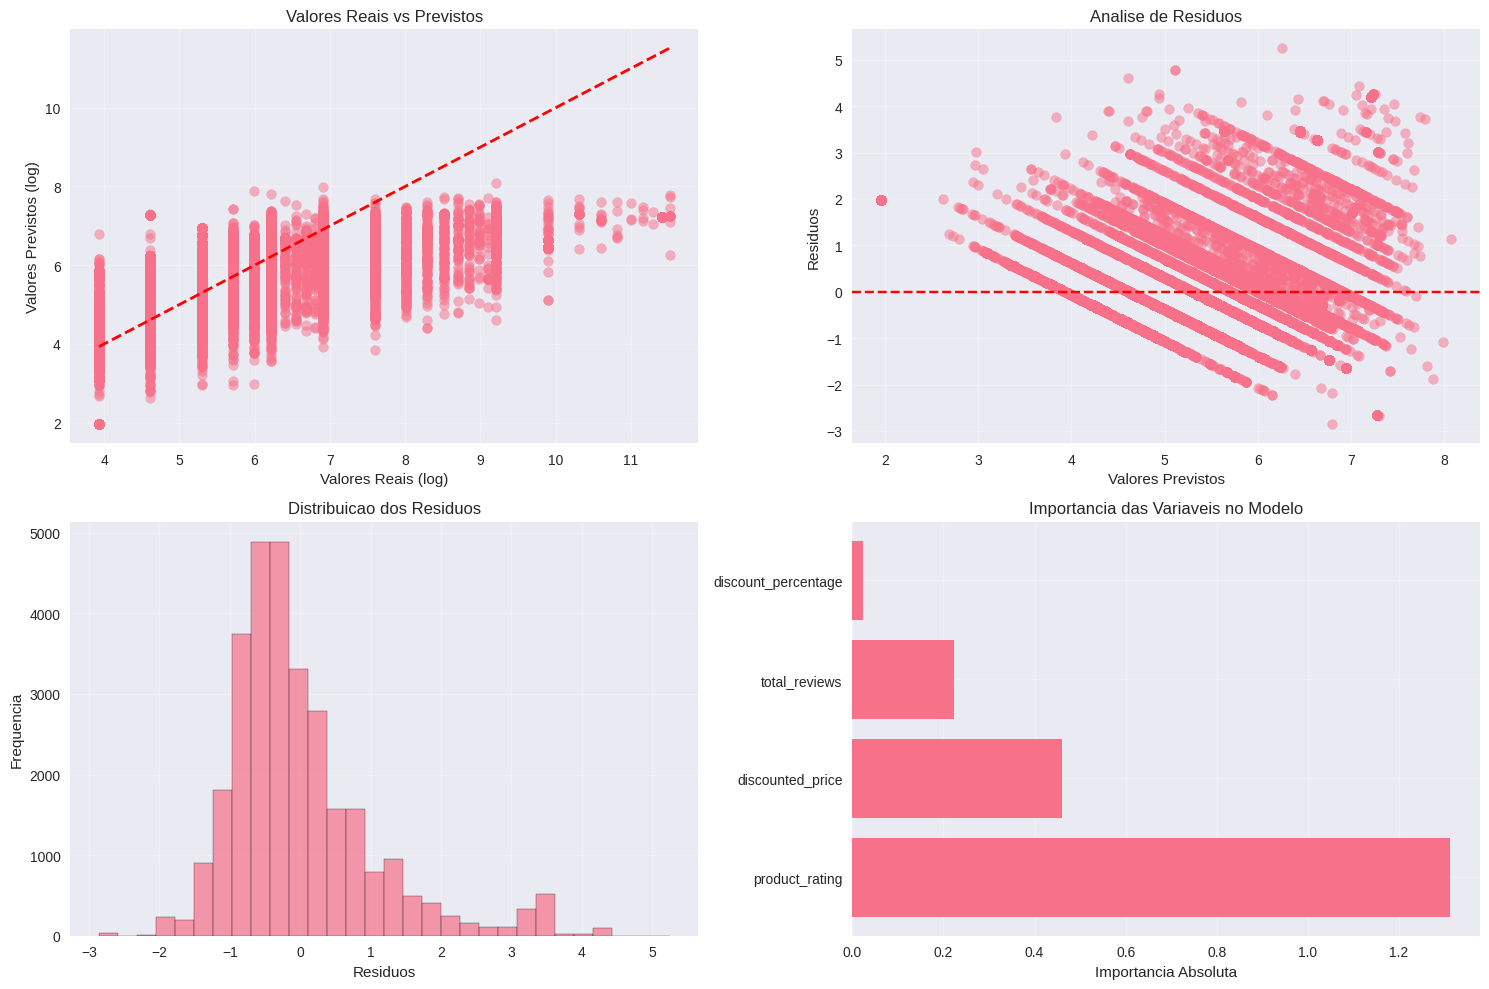


INTERPRETACAO DOS RESULTADOS:
  product_rating: Efeito positivo nas vendas (coeficiente: 1.3120)
  discounted_price: Efeito negativo nas vendas (coeficiente: -0.4609)
  total_reviews: Efeito positivo nas vendas (coeficiente: 0.2222)
  discount_percentage: Efeito positivo nas vendas (coeficiente: 0.0234)


In [41]:
# 18. ANALISE DE REGRESSAO MULTIVARIADA AVANCADA
print("=== ANALISE DE REGRESSAO MULTIVARIADA ===")

if 'purchased_last_month' in df_clean.columns and len(X) > 0:

    # Preparar dados para regressao
    regression_data = df_clean[['discounted_price', 'product_rating', 'total_reviews',
                               'discount_percentage', 'purchased_last_month']].dropna()

    if len(regression_data) > 100:
        # Definir variaveis independentes e dependente
        X_reg = regression_data[['discounted_price', 'product_rating', 'total_reviews', 'discount_percentage']]
        y_reg = regression_data['purchased_last_month']

        # Aplicar transformacao logaritmica para normalizar
        X_reg_log = np.log1p(X_reg)
        y_reg_log = np.log1p(y_reg)

        # Modelo de regressao linear
        from sklearn.linear_model import LinearRegression
        from sklearn.metrics import mean_squared_error, r2_score

        model = LinearRegression()
        model.fit(X_reg_log, y_reg_log)

        # Previsoes
        y_pred_log = model.predict(X_reg_log)

        # Metricas do modelo
        mse = mean_squared_error(y_reg_log, y_pred_log)
        r2 = r2_score(y_reg_log, y_pred_log)

        print("Resultados da Regressao Linear Multivariada:")
        print(f"R-quadrado: {r2:.4f}")
        print(f"Erro Quadratico Medio: {mse:.4f}")
        print(f"Raiz do Erro Quadratico Medio: {np.sqrt(mse):.4f}")

        # Coeficientes da regressao
        coefficients = pd.DataFrame({
            'Variavel': X_reg.columns,
            'Coeficiente': model.coef_,
            'Importancia_Absoluta': np.abs(model.coef_)
        }).sort_values('Importancia_Absoluta', ascending=False)

        print("\nCoeficientes da Regressao:")
        print(coefficients)

        # Visualizacao dos resultados
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # 1. Valores reais vs previstos
        axes[0,0].scatter(y_reg_log, y_pred_log, alpha=0.5)
        axes[0,0].plot([y_reg_log.min(), y_reg_log.max()], [y_reg_log.min(), y_reg_log.max()], 'r--', lw=2)
        axes[0,0].set_xlabel('Valores Reais (log)')
        axes[0,0].set_ylabel('Valores Previstos (log)')
        axes[0,0].set_title('Valores Reais vs Previstos')
        axes[0,0].grid(True, alpha=0.3)

        # 2. Residuos
        residuals = y_reg_log - y_pred_log
        axes[0,1].scatter(y_pred_log, residuals, alpha=0.5)
        axes[0,1].axhline(y=0, color='r', linestyle='--')
        axes[0,1].set_xlabel('Valores Previstos')
        axes[0,1].set_ylabel('Residuos')
        axes[0,1].set_title('Analise de Residuos')
        axes[0,1].grid(True, alpha=0.3)

        # 3. Distribuicao dos residuos
        axes[1,0].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
        axes[1,0].set_xlabel('Residuos')
        axes[1,0].set_ylabel('Frequencia')
        axes[1,0].set_title('Distribuicao dos Residuos')
        axes[1,0].grid(True, alpha=0.3)

        # 4. Importancia das variaveis
        axes[1,1].barh(coefficients['Variavel'], coefficients['Importancia_Absoluta'])
        axes[1,1].set_xlabel('Importancia Absoluta')
        axes[1,1].set_title('Importancia das Variaveis no Modelo')
        axes[1,1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Interpretacao dos resultados
        print("\nINTERPRETACAO DOS RESULTADOS:")
        for _, row in coefficients.iterrows():
            var = row['Variavel']
            coef = row['Coeficiente']
            if coef > 0:
                print(f"  {var}: Efeito positivo nas vendas (coeficiente: {coef:.4f})")
            else:
                print(f"  {var}: Efeito negativo nas vendas (coeficiente: {coef:.4f})")

=== ANÁLISE TEMPORAL - PADRÕES DIÁRIOS E HORÁRIOS ===
Período dos dados: 2025-08-21 a 2025-08-30
Dias com dados: 6
Horas com dados: 9

ANÁLISE POR DIA:
            purchased_last_month_sum  purchased_last_month_mean  \
date                                                              
2025-08-21                15876900.0                    2273.65   
2025-08-24                 2840500.0                     508.05   
2025-08-25                 2140000.0                     583.42   
2025-08-27                10987350.0                    3424.98   
2025-08-29                 6291750.0                    1006.84   
2025-08-30                 3472950.0                     537.19   

            purchased_last_month_count  discounted_price_mean  \
date                                                            
2025-08-21                        6983                 167.04   
2025-08-24                        5591                 228.17   
2025-08-25                        3668             

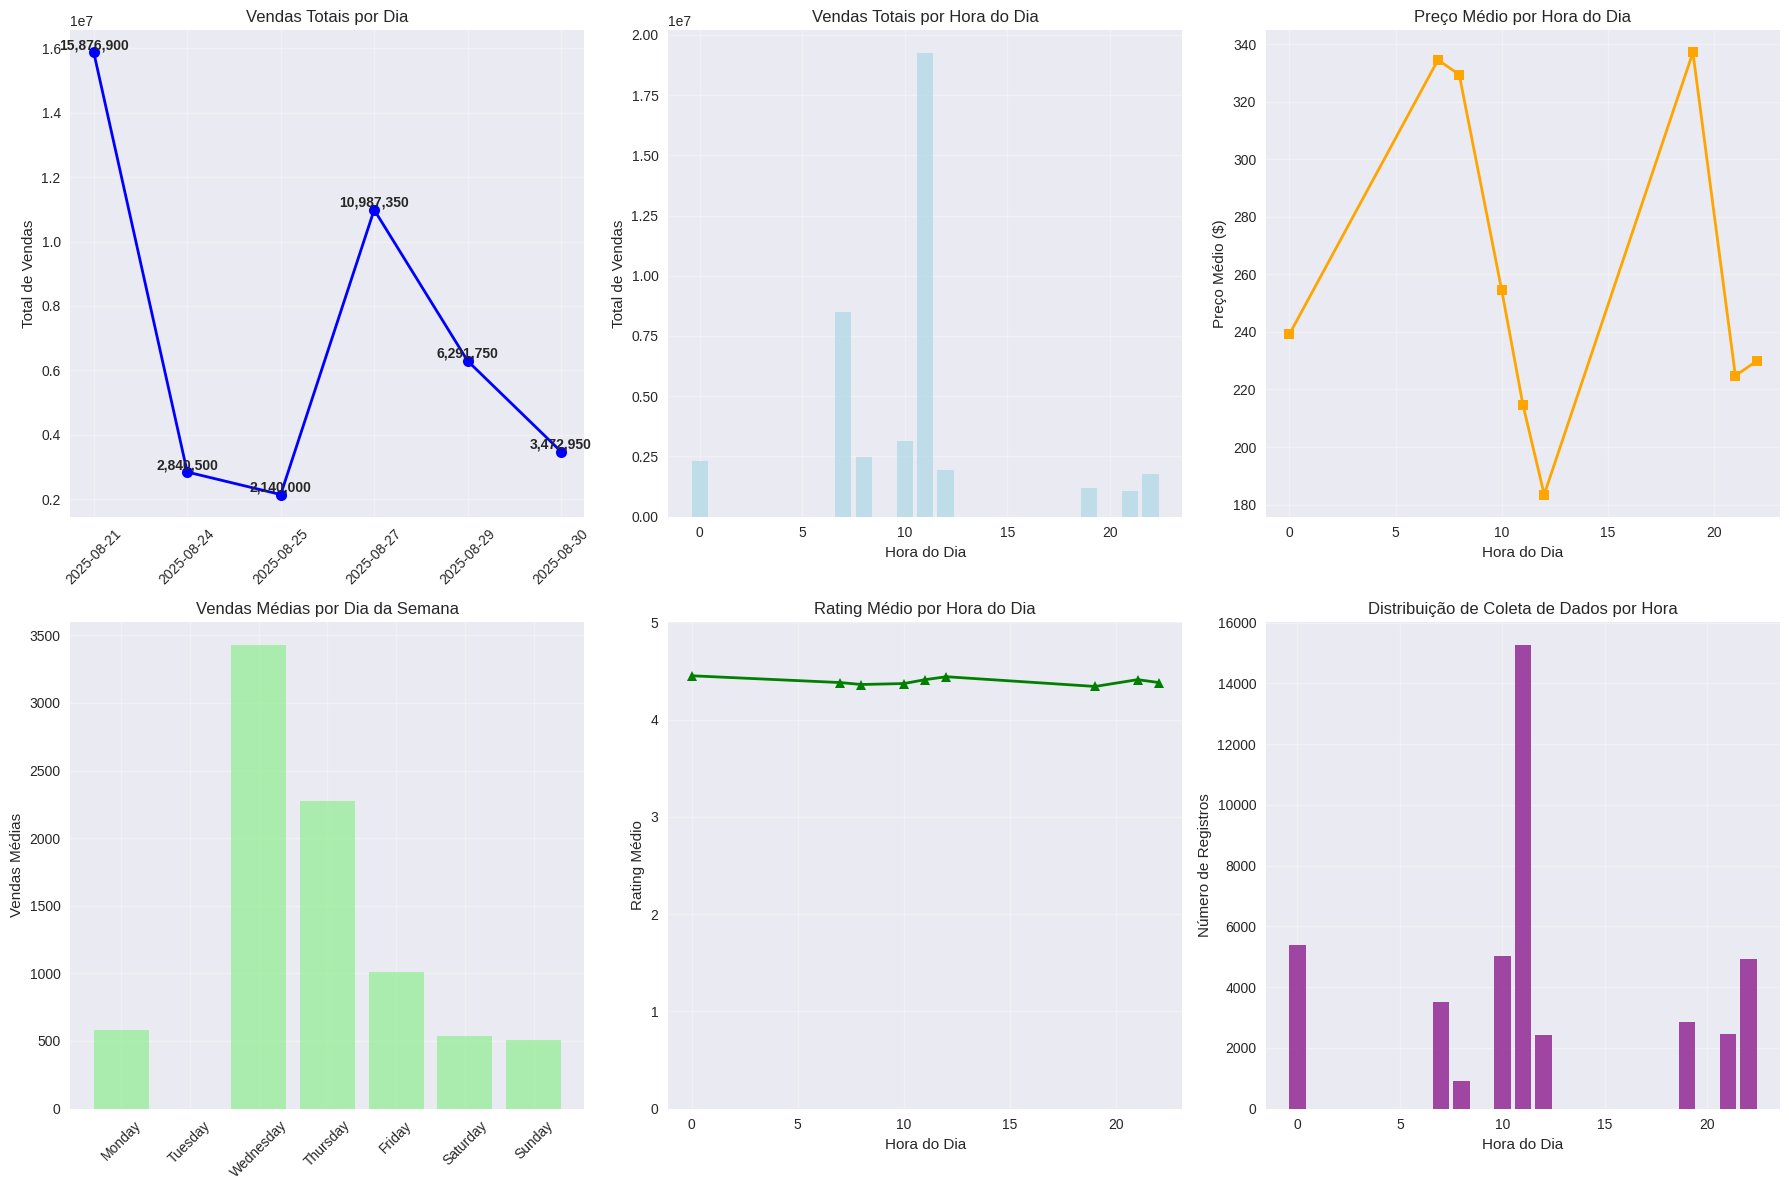


=== CORRELAÇÕES TEMPORAIS ===
Correlação entre hora do dia e métricas de performance:
hour                    1.000000
discounted_price       -0.004235
discount_percentage    -0.008336
purchased_last_month   -0.036944
product_rating         -0.043867
Name: hour, dtype: float64

ANÁLISE POR PERÍODO DO DIA:
             purchased_last_month_mean  purchased_last_month_sum  \
time_period                                                        
Madrugada                       531.69                 2295850.0   
Manhã                          1755.32                35296000.0   
Tarde                              NaN                       0.0   
Noite                           519.20                 4017600.0   

             discounted_price_mean  product_rating_mean  \
time_period                                               
Madrugada                   239.14                 4.45   
Manhã                       238.49                 4.40   
Tarde                          NaN             

In [46]:
# 19. ANÁLISE TEMPORAL ADAPTADA PARA DADOS DE CURTO PRAZO
print("=== ANÁLISE TEMPORAL - PADRÕES DIÁRIOS E HORÁRIOS ===")

# Converter para datetime se necessário
if df_clean['data_collected_at'].dtype == 'object':
    df_clean['data_collected_at'] = pd.to_datetime(df_clean['data_collected_at'], errors='coerce')

# Extrair componentes de tempo
df_clean['date'] = df_clean['data_collected_at'].dt.date
df_clean['day_of_week'] = df_clean['data_collected_at'].dt.day_name()
df_clean['hour'] = df_clean['data_collected_at'].dt.hour
df_clean['day_number'] = df_clean['data_collected_at'].dt.day

print(f"Período dos dados: {df_clean['date'].min()} a {df_clean['date'].max()}")
print(f"Dias com dados: {df_clean['date'].nunique()}")
print(f"Horas com dados: {df_clean['hour'].nunique()}")

# Análise por dia
daily_analysis = df_clean.groupby('date').agg({
    'purchased_last_month': ['sum', 'mean', 'count'],
    'discounted_price': 'mean',
    'product_rating': 'mean',
    'discount_percentage': 'mean',
    'total_reviews': 'sum'
}).round(2)

daily_analysis.columns = ['_'.join(col).strip() for col in daily_analysis.columns.values]
print("\nANÁLISE POR DIA:")
print(daily_analysis)

# Análise por hora do dia
hourly_analysis = df_clean.groupby('hour').agg({
    'purchased_last_month': ['sum', 'mean', 'count'],
    'discounted_price': 'mean',
    'product_rating': 'mean'
}).round(2)

hourly_analysis.columns = ['_'.join(col).strip() for col in hourly_analysis.columns.values]
print("\nANÁLISE POR HORA DO DIA:")
print(hourly_analysis)

# Análise por dia da semana
weekday_analysis = df_clean.groupby('day_of_week').agg({
    'purchased_last_month': ['sum', 'mean', 'count'],
    'discounted_price': 'mean',
    'product_rating': 'mean',
    'discount_percentage': 'mean'
}).round(2)

weekday_analysis.columns = ['_'.join(col).strip() for col in weekday_analysis.columns.values]
print("\nANÁLISE POR DIA DA SEMANA:")
print(weekday_analysis)

# Visualização dos padrões temporais de curto prazo
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Vendas totais por dia
if len(daily_analysis) > 1:
    axes[0,0].plot(daily_analysis.index.astype(str), daily_analysis['purchased_last_month_sum'],
                  marker='o', linewidth=2, color='blue', markersize=8)
    axes[0,0].set_title('Vendas Totais por Dia')
    axes[0,0].set_ylabel('Total de Vendas')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(True, alpha=0.3)

    # Adicionar valores nos pontos
    for i, v in enumerate(daily_analysis['purchased_last_month_sum']):
        axes[0,0].text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontweight='bold')

# 2. Vendas por hora do dia
if len(hourly_analysis) > 1:
    axes[0,1].bar(hourly_analysis.index, hourly_analysis['purchased_last_month_sum'],
                 color='lightblue', alpha=0.7)
    axes[0,1].set_title('Vendas Totais por Hora do Dia')
    axes[0,1].set_xlabel('Hora do Dia')
    axes[0,1].set_ylabel('Total de Vendas')
    axes[0,1].grid(True, alpha=0.3)

# 3. Preço médio por hora
if len(hourly_analysis) > 1:
    axes[0,2].plot(hourly_analysis.index, hourly_analysis['discounted_price_mean'],
                  marker='s', color='orange', linewidth=2)
    axes[0,2].set_title('Preço Médio por Hora do Dia')
    axes[0,2].set_xlabel('Hora do Dia')
    axes[0,2].set_ylabel('Preço Médio ($)')
    axes[0,2].grid(True, alpha=0.3)

# 4. Vendas médias por dia da semana
if len(weekday_analysis) > 1:
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekday_analysis = weekday_analysis.reindex(weekday_order, fill_value=0)

    axes[1,0].bar(weekday_analysis.index, weekday_analysis['purchased_last_month_mean'],
                 color='lightgreen', alpha=0.7)
    axes[1,0].set_title('Vendas Médias por Dia da Semana')
    axes[1,0].set_ylabel('Vendas Médias')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(True, alpha=0.3)

# 5. Rating médio por hora
if len(hourly_analysis) > 1:
    axes[1,1].plot(hourly_analysis.index, hourly_analysis['product_rating_mean'],
                  marker='^', color='green', linewidth=2)
    axes[1,1].set_title('Rating Médio por Hora do Dia')
    axes[1,1].set_xlabel('Hora do Dia')
    axes[1,1].set_ylabel('Rating Médio')
    axes[1,1].set_ylim(0, 5)
    axes[1,1].grid(True, alpha=0.3)

# 6. Densidade de coleta de dados por hora
if 'hour' in df_clean.columns:
    hour_counts = df_clean['hour'].value_counts().sort_index()
    axes[1,2].bar(hour_counts.index, hour_counts.values, color='purple', alpha=0.7)
    axes[1,2].set_title('Distribuição de Coleta de Dados por Hora')
    axes[1,2].set_xlabel('Hora do Dia')
    axes[1,2].set_ylabel('Número de Registros')
    axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análise de correlações temporais
print("\n=== CORRELAÇÕES TEMPORAIS ===")

# Correlação entre hora do dia e métricas de performance
temporal_correlations = df_clean[['hour', 'purchased_last_month', 'discounted_price',
                                'product_rating', 'discount_percentage']].corr()

print("Correlação entre hora do dia e métricas de performance:")
print(temporal_correlations['hour'].sort_values(ascending=False))

# Análise de padrões de preço por período do dia
df_clean['time_period'] = pd.cut(df_clean['hour'],
                               bins=[0, 6, 12, 18, 24],
                               labels=['Madrugada', 'Manhã', 'Tarde', 'Noite'],
                               include_lowest=True)

time_period_analysis = df_clean.groupby('time_period').agg({
    'purchased_last_month': ['mean', 'sum'],
    'discounted_price': 'mean',
    'product_rating': 'mean',
    'discount_percentage': 'mean'
}).round(2)

time_period_analysis.columns = ['_'.join(col).strip() for col in time_period_analysis.columns.values]
print("\nANÁLISE POR PERÍODO DO DIA:")
print(time_period_analysis)

# Insights sobre padrões temporais
print("\n=== INSIGHTS SOBRE PADRÕES TEMPORAIS ===")

if len(daily_analysis) > 1:
    best_day = daily_analysis['purchased_last_month_sum'].idxmax()
    worst_day = daily_analysis['purchased_last_month_sum'].idxmin()
    best_day_sales = daily_analysis['purchased_last_month_sum'].max()
    worst_day_sales = daily_analysis['purchased_last_month_sum'].min()

    print(f"Melhor dia de vendas: {best_day} (${best_day_sales:,.0f})")
    print(f"Pior dia de vendas: {worst_day} (${worst_day_sales:,.0f})")

    daily_variation = ((best_day_sales - worst_day_sales) / worst_day_sales) * 100
    print(f"Variação entre melhor e pior dia: {daily_variation:.1f}%")

if len(hourly_analysis) > 1:
    best_hour = hourly_analysis['purchased_last_month_sum'].idxmax()
    worst_hour = hourly_analysis['purchased_last_month_sum'].idxmin()
    best_hour_sales = hourly_analysis['purchased_last_month_sum'].max()

    print(f"Melhor horário para vendas: {best_hour}:00h")
    print(f"Pior horário para vendas: {worst_hour}:00h")
    print(f"Pico de vendas no horário {best_hour}:00h: {best_hour_sales:,.0f} unidades")

if len(time_period_analysis) > 1:
    best_period = time_period_analysis['purchased_last_month_mean'].idxmax()
    best_period_sales = time_period_analysis['purchased_last_month_mean'].max()
    print(f"Melhor período do dia para vendas: {best_period} (média: {best_period_sales:.1f} vendas/produto)")

# Análise de tendência intra-diária
print("\n=== TENDÊNCIA INTRADIÁRIA ===")

if len(daily_analysis) > 2:
    # Calcular crescimento diário
    daily_growth = daily_analysis['purchased_last_month_sum'].pct_change() * 100
    print("Crescimento diário das vendas:")
    for date, growth in daily_growth.items():
        if not pd.isna(growth):
            print(f"  {date}: {growth:+.1f}%")

# Análise de consistência temporal
print("\n=== CONSISTÊNCIA TEMPORAL ===")

daily_volatility = daily_analysis['purchased_last_month_sum'].std() / daily_analysis['purchased_last_month_sum'].mean() * 100
hourly_volatility = hourly_analysis['purchased_last_month_sum'].std() / hourly_analysis['purchased_last_month_sum'].mean() * 100

print(f"Volatilidade diária das vendas: {daily_volatility:.1f}%")
print(f"Volatilidade horária das vendas: {hourly_volatility:.1f}%")

if daily_volatility < 20:
    print("Padrão: Vendas consistentes entre os dias")
else:
    print("Padrão: Vendas voláteis entre os dias")

if hourly_volatility < 30:
    print("Padrão: Vendas consistentes ao longo do dia")
else:
    print("Padrão: Vendas com picos horários significativos")

=== COMPORTAMENTO TEMPORAL POR CATEGORIA ===


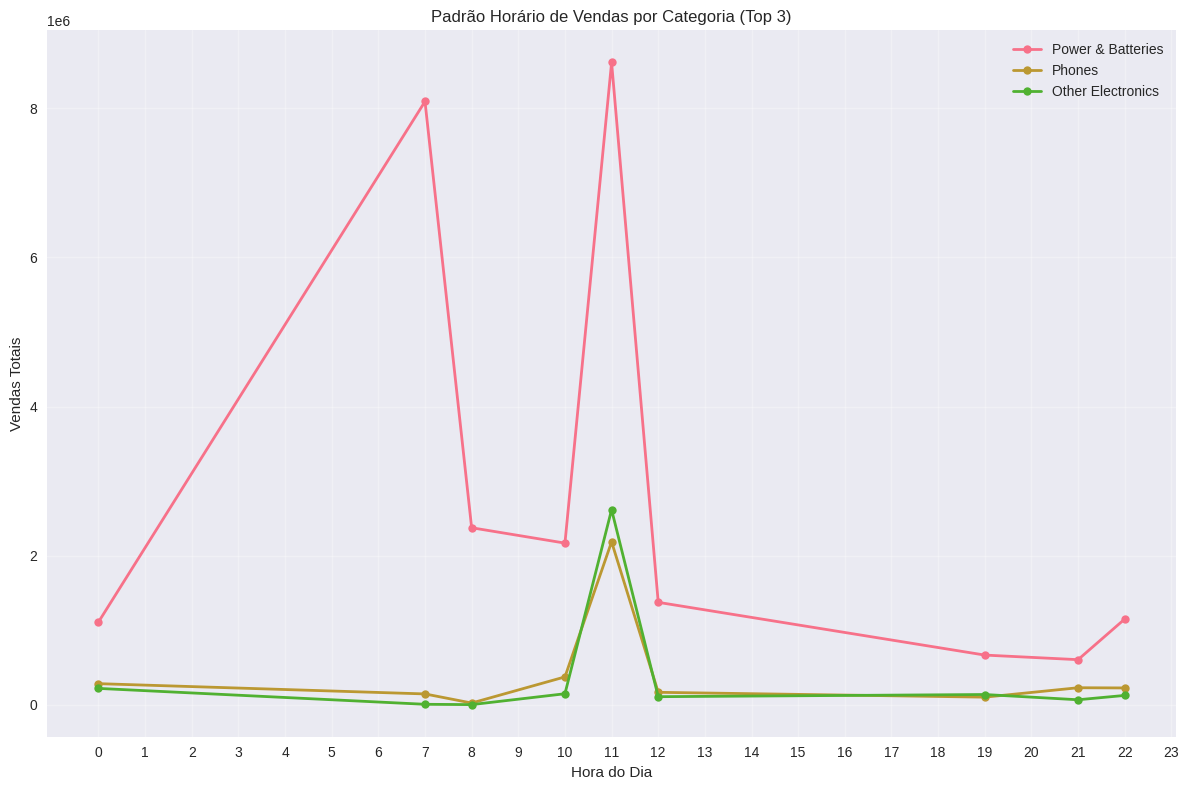

CATEGORIAS COM PADRÕES TEMPORAIS DISTINTOS:
Power & Batteries:
  Pico às 11:00h (8,615,800 vendas)
  Vale às 21:00h
Phones:
  Pico às 11:00h (2,185,350 vendas)
  Vale às 8:00h
Other Electronics:
  Pico às 11:00h (2,616,350 vendas)
  Vale às 8:00h


In [47]:
# 20. ANÁLISE COMPORTAMENTAL TEMPORAL POR CATEGORIA
print("=== COMPORTAMENTO TEMPORAL POR CATEGORIA ===")

if 'product_category' in df_clean.columns:
    # Análise por categoria e hora
    category_hour_analysis = df_clean.groupby(['product_category', 'hour']).agg({
        'purchased_last_month': 'sum',
        'discounted_price': 'mean'
    }).reset_index()

    # Top categorias por volume
    top_categories = df_clean.groupby('product_category')['purchased_last_month'].sum().nlargest(3).index

    # Plotar padrão horário por categoria
    plt.figure(figsize=(12, 8))

    for category in top_categories:
        cat_data = category_hour_analysis[category_hour_analysis['product_category'] == category]
        if len(cat_data) > 1:
            plt.plot(cat_data['hour'], cat_data['purchased_last_month'],
                    marker='o', linewidth=2, label=category, markersize=6)

    plt.title('Padrão Horário de Vendas por Categoria (Top 3)')
    plt.xlabel('Hora do Dia')
    plt.ylabel('Vendas Totais')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(range(0, 24))
    plt.tight_layout()
    plt.show()

    # Análise de categorias com padrões diferentes
    print("CATEGORIAS COM PADRÕES TEMPORAIS DISTINTOS:")

    for category in top_categories:
        cat_data = category_hour_analysis[category_hour_analysis['product_category'] == category]
        if len(cat_data) > 1:
            peak_hour = cat_data.loc[cat_data['purchased_last_month'].idxmax(), 'hour']
            off_peak_hour = cat_data.loc[cat_data['purchased_last_month'].idxmin(), 'hour']
            peak_sales = cat_data['purchased_last_month'].max()

            print(f"{category}:")
            print(f"  Pico às {peak_hour}:00h ({peak_sales:,.0f} vendas)")
            print(f"  Vale às {off_peak_hour}:00h")


In [50]:
# PRIMEIRO: EXECUTAR O ETL ROBUSTO COMPLETO
print("=== EXECUTANDO ETL ROBUSTO COMPLETO ===")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Função de ETL Robusta
def advanced_data_cleaning(df):
    df_clean = df.copy()

    # 1. Padronização de colunas
    df_clean.columns = [c.strip().lower().replace(" ", "_") for c in df_clean.columns]

    # 2. Conversão de tipos de dados
    # Converter data
    df_clean['data_collected_at'] = pd.to_datetime(df_clean['data_collected_at'], errors='coerce')

    # Converter colunas numéricas
    numeric_columns = ['discounted_price', 'original_price', 'discount_percentage',
                      'product_rating', 'total_reviews', 'purchased_last_month']

    for col in numeric_columns:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    # 3. Tratamento de valores missing
    print("Tratamento de valores missing:")

    # Preencher ratings missing com mediana por categoria
    if 'product_rating' in df_clean.columns and 'product_category' in df_clean.columns:
        rating_median_by_category = df_clean.groupby('product_category')['product_rating'].transform('median')
        df_clean['product_rating'] = df_clean['product_rating'].fillna(rating_median_by_category)
        print(f"  - Ratings missing preenchidos: {df_clean['product_rating'].isna().sum()}")

    # Preencher reviews missing com 0
    if 'total_reviews' in df_clean.columns:
        df_clean['total_reviews'] = df_clean['total_reviews'].fillna(0)
        print(f"  - Reviews missing preenchidos: {df_clean['total_reviews'].isna().sum()}")

    # Preencher vendas missing com mediana por categoria
    if 'purchased_last_month' in df_clean.columns and 'product_category' in df_clean.columns:
        sales_median_by_category = df_clean.groupby('product_category')['purchased_last_month'].transform('median')
        df_clean['purchased_last_month'] = df_clean['purchased_last_month'].fillna(sales_median_by_category)
        print(f"  - Vendas missing preenchidos: {df_clean['purchased_last_month'].isna().sum()}")

    # 4. Remoção de outliers usando IQR
    print("\nRemoção de outliers:")

    def remove_outliers_iqr(df, column):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    outlier_cols = ['discounted_price', 'purchased_last_month', 'total_reviews']
    initial_count = len(df_clean)

    for col in outlier_cols:
        if col in df_clean.columns:
            before = len(df_clean)
            df_clean = remove_outliers_iqr(df_clean, col)
            after = len(df_clean)
            removed = before - after
            print(f"  - {col}: removidos {removed} outliers ({removed/before*100:.1f}%)")

    # 5. Engenharia de features
    print("\nEngenharia de features:")

    # Feature: Receita estimada
    df_clean['estimated_revenue'] = df_clean['discounted_price'] * df_clean['purchased_last_month']

    # Feature: Eficiência de reviews (vendas por review)
    df_clean['review_efficiency'] = df_clean['purchased_last_month'] / (df_clean['total_reviews'] + 1)

    # Feature: Valor percebido (rating por preço)
    df_clean['value_perception'] = df_clean['product_rating'] / (df_clean['discounted_price'] + 1)

    # Feature: Categorização de preço
    price_bins = [0, 50, 100, 200, 500, 1000, float('inf')]
    price_labels = ['Muito Baixo', 'Baixo', 'Médio', 'Alto', 'Muito Alto', 'Premium']
    df_clean['price_category'] = pd.cut(df_clean['discounted_price'], bins=price_bins, labels=price_labels)

    # Feature: Categorização de rating
    rating_bins = [0, 3, 4, 4.5, 5]
    rating_labels = ['Ruim', 'Regular', 'Bom', 'Excelente']
    df_clean['rating_category'] = pd.cut(df_clean['product_rating'], bins=rating_bins, labels=rating_labels)

    # Feature: Categorização de vendas
    sales_bins = [0, 10, 50, 100, 500, float('inf')]
    sales_labels = ['Muito Baixas', 'Baixas', 'Médias', 'Altas', 'Muito Altas']
    df_clean['sales_category'] = pd.cut(df_clean['purchased_last_month'], bins=sales_bins, labels=sales_labels)

    print(f"  - 5 novas features criadas")

    # 6. Remover duplicatas
    df_clean = df_clean.drop_duplicates()

    print(f"\nResumo da limpeza:")
    print(f"  - Registros iniciais: {initial_count}")
    print(f"  - Registros finais: {len(df_clean)}")
    print(f"  - Redução: {((initial_count - len(df_clean)) / initial_count * 100):.1f}%")

    return df_clean

# Aplicar ETL robusto ao dataframe original
df_robust = advanced_data_cleaning(df)
print(f"\nDataFrame robusto criado: {df_robust.shape}")

# SALVAR TAMBÉM O DATAFRAME COM ETL BÁSICO PARA COMPARAÇÃO
print("\n=== CRIANDO DATAFRAME COM ETL BÁSICO ===")

# Função de ETL básico (similar à anterior)
def basic_data_cleaning(df):
    df_clean = df.copy()
    # Padronizar nomes das colunas
    df_clean.columns = [c.strip().lower().replace(" ", "_") for c in df_clean.columns]

    # Converter para numéricos
    numeric_columns = ['discounted_price', 'original_price', 'discount_percentage',
                      'product_rating', 'total_reviews', 'purchased_last_month']

    for col in numeric_columns:
        if col in df_clean.columns:
            # Remover caracteres não numéricos e converter
            df_clean[col] = pd.to_numeric(df_clean[col].astype(str).str.replace(r'[^\d.-]', '', regex=True), errors='coerce')

    # Remover duplicatas
    df_clean = df_clean.drop_duplicates()
    return df_clean

# Aplicar ETL básico
df_basic = basic_data_cleaning(df)
print(f"DataFrame básico criado: {df_basic.shape}")

# COMPARAÇÃO ENTRE OS DOIS DATAFRAMES
print("\n=== COMPARAÇÃO ENTRE ETL BÁSICO E ETL ROBUSTO ===")

def compare_dataframes(df1, df2, name1="ETL Básico", name2="ETL Robusto"):
    comparison = {
        'registros': [len(df1), len(df2), f"{((len(df2)-len(df1))/len(df1)*100):+.1f}%"],
        'colunas': [df1.shape[1], df2.shape[1], f"{df2.shape[1] - df1.shape[1]}"],
        'missing_total': [df1.isna().sum().sum(), df2.isna().sum().sum(), f"{((df2.isna().sum().sum()-df1.isna().sum().sum())/df1.isna().sum().sum()*100):+.1f}%"],
        'duplicatas': [df1.duplicated().sum(), df2.duplicated().sum(), f"{df2.duplicated().sum() - df1.duplicated().sum()}"]
    }

    comparison_df = pd.DataFrame(comparison, index=[name1, name2, 'Diferença'])
    return comparison_df

# Comparação geral
comparison = compare_dataframes(df_basic, df_robust)
print("Comparação geral entre os dataframes:")
print(comparison)

=== EXECUTANDO ETL ROBUSTO COMPLETO ===
Tratamento de valores missing:
  - Ratings missing preenchidos: 0
  - Reviews missing preenchidos: 0
  - Vendas missing preenchidos: 0

Remoção de outliers:
  - discounted_price: removidos 6950 outliers (16.3%)
  - purchased_last_month: removidos 4853 outliers (13.6%)
  - total_reviews: removidos 3792 outliers (12.3%)

Engenharia de features:
  - 5 novas features criadas

Resumo da limpeza:
  - Registros iniciais: 42675
  - Registros finais: 27080
  - Redução: 36.5%

DataFrame robusto criado: (27080, 23)

=== CRIANDO DATAFRAME COM ETL BÁSICO ===
DataFrame básico criado: (42675, 17)

=== COMPARAÇÃO ENTRE ETL BÁSICO E ETL ROBUSTO ===
Comparação geral entre os dataframes:
            registros colunas missing_total duplicatas
ETL Básico      42675      17         86717          0
ETL Robusto     27080      23         41789          0
Diferença      -36.5%       6        -51.8%          0


In [51]:
# ANÁLISE DE QUALIDADE PÓS-LIMPEZA
print("=== QUALIDADE DOS DADOS APÓS LIMPEZA ===")

def quality_report(df):
    report = {
        'total_registros': len(df),
        'colunas': df.shape[1],
        'registros_duplicados': df.duplicated().sum(),
        'missing_data': df.isna().sum().sum(),
        'missing_por_coluna': (df.isna().sum() / len(df) * 100).round(2).to_dict()
    }
    return report

quality_basic = quality_report(df_basic)
quality_robust = quality_report(df_robust)

print("ETL BÁSICO - Relatório de qualidade:")
for key, value in quality_basic.items():
    if key != 'missing_por_coluna':
        print(f"  {key}: {value}")

print("\nETL ROBUSTO - Relatório de qualidade:")
for key, value in quality_robust.items():
    if key != 'missing_por_coluna':
        print(f"  {key}: {value}")

print("\nMissing por coluna - COMPARAÇÃO:")
print("Coluna | ETL Básico | ETL Robusto | Melhoria")
print("-" * 50)
for col in quality_basic['missing_por_coluna']:
    if col in quality_robust['missing_por_coluna']:
        basic_pct = quality_basic['missing_por_coluna'][col]
        robust_pct = quality_robust['missing_por_coluna'][col]
        if basic_pct > 0 or robust_pct > 0:
            improvement = basic_pct - robust_pct
            print(f"{col:20} | {basic_pct:8.1f}% | {robust_pct:8.1f}% | {improvement:+.1f}%")

=== QUALIDADE DOS DADOS APÓS LIMPEZA ===
ETL BÁSICO - Relatório de qualidade:
  total_registros: 42675
  colunas: 17
  registros_duplicados: 0
  missing_data: 86717

ETL ROBUSTO - Relatório de qualidade:
  total_registros: 27080
  colunas: 23
  registros_duplicados: 0
  missing_data: 41789

Missing por coluna - COMPARAÇÃO:
Coluna | ETL Básico | ETL Robusto | Melhoria
--------------------------------------------------
product_rating       |      2.4% |      0.0% | +2.4%
total_reviews        |      2.4% |      0.0% | +2.4%
purchased_last_month |     24.6% |      0.0% | +24.6%
discounted_price     |      4.8% |      0.0% | +4.8%
original_price       |      4.8% |      0.0% | +4.8%
buy_box_availability |     34.3% |     33.7% | +0.7%
delivery_date        |     28.1% |     26.2% | +1.9%
sustainability_tags  |     92.0% |     93.8% | -1.8%
product_page_url     |      4.8% |      0.7% | +4.2%
discount_percentage  |      4.8% |      0.0% | +4.8%


=== ANÁLISE EXPLORATÓRIA COMPARATIVA ===
Comparação de estatísticas por variável:
                      Básico_mean  Robusto_mean  diff_mean  Básico_std  \
discounted_price           243.23        125.53    -117.70      473.35   
product_rating               4.40          4.37      -0.03        0.39   
total_reviews             3087.11        601.13   -2485.97    13030.46   
purchased_last_month      1293.67        183.51   -1110.16     6318.32   

                      Robusto_std  diff_std  Básico_count  Robusto_count  
discounted_price           117.19   -356.16       40613.0        27080.0  
product_rating               0.36     -0.03       41651.0        27080.0  
total_reviews              781.97 -12248.49       41651.0        27080.0  
purchased_last_month       115.15  -6203.18       32164.0        27080.0  


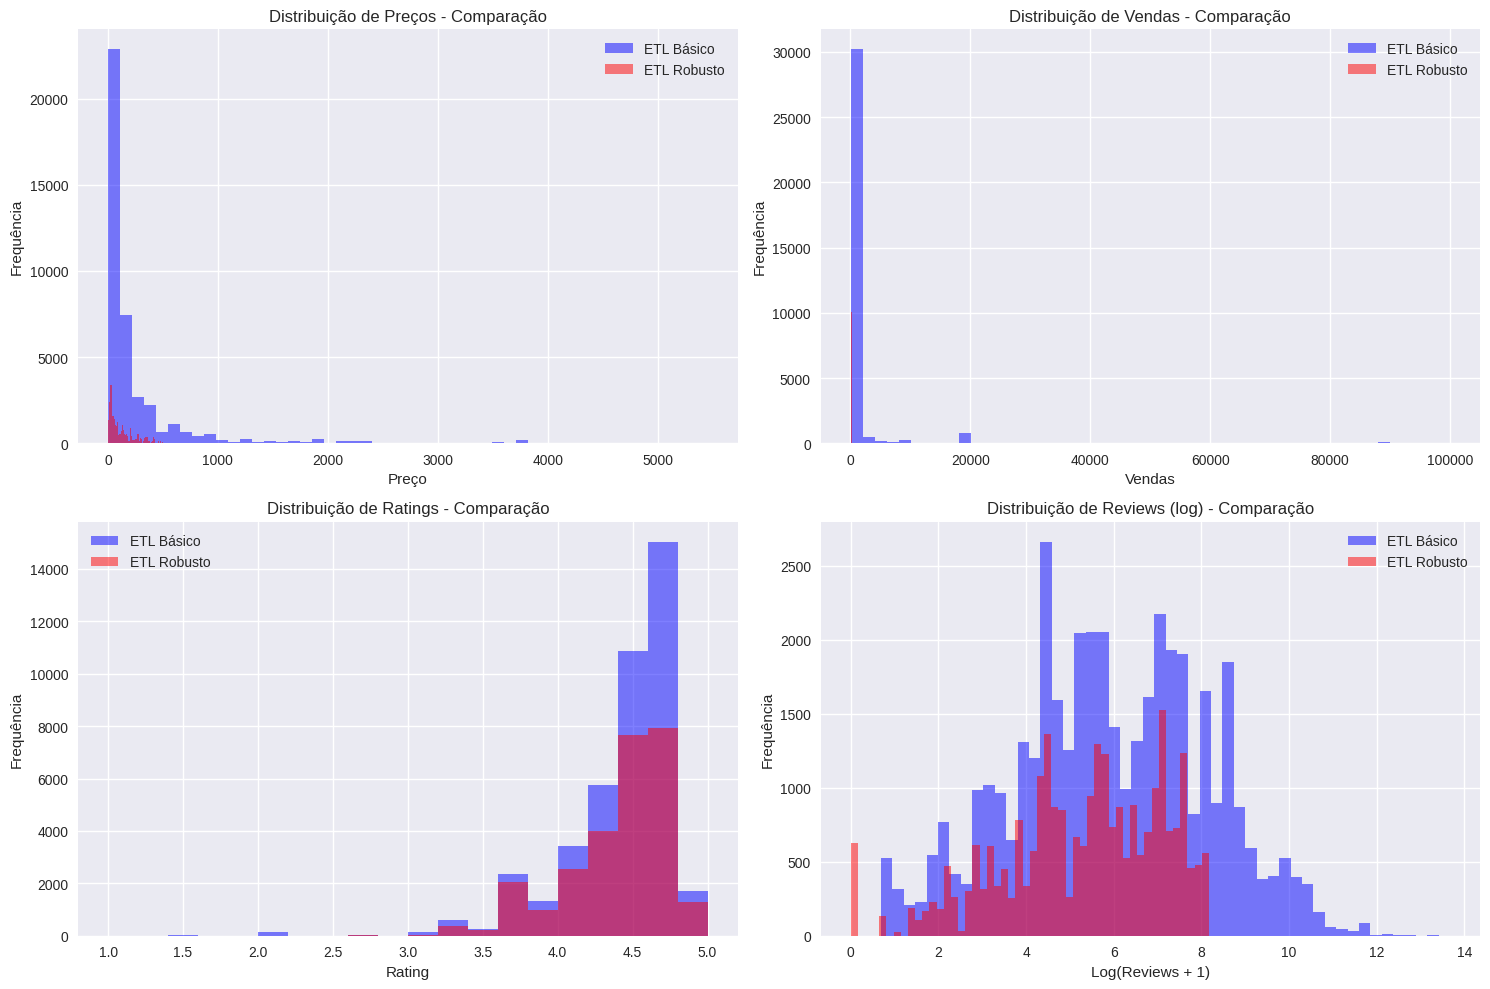

In [52]:
# ANÁLISE EXPLORATÓRIA COMPARATIVA
print("=== ANÁLISE EXPLORATÓRIA COMPARATIVA ===")

# Estatísticas descritivas comparativas
def compare_stats(df1, df2, columns, name1="Básico", name2="Robusto"):
    stats_comparison = {}

    for col in columns:
        if col in df1.columns and col in df2.columns:
            stats1 = df1[col].describe()
            stats2 = df2[col].describe()

            stats_comparison[col] = {
                f'{name1}_mean': stats1['mean'],
                f'{name2}_mean': stats2['mean'],
                'diff_mean': stats2['mean'] - stats1['mean'],
                f'{name1}_std': stats1['std'],
                f'{name2}_std': stats2['std'],
                'diff_std': stats2['std'] - stats1['std'],
                f'{name1}_count': stats1['count'],
                f'{name2}_count': stats2['count']
            }

    return pd.DataFrame(stats_comparison).T.round(2)

numeric_cols_compare = ['discounted_price', 'product_rating', 'total_reviews', 'purchased_last_month']
stats_comparison = compare_stats(df_basic, df_robust, numeric_cols_compare)
print("Comparação de estatísticas por variável:")
print(stats_comparison)

# Visualização comparativa das distribuições
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Preços
axes[0,0].hist(df_basic['discounted_price'].dropna(), bins=50, alpha=0.5, label='ETL Básico', color='blue')
axes[0,0].hist(df_robust['discounted_price'].dropna(), bins=50, alpha=0.5, label='ETL Robusto', color='red')
axes[0,0].set_title('Distribuição de Preços - Comparação')
axes[0,0].set_xlabel('Preço')
axes[0,0].set_ylabel('Frequência')
axes[0,0].legend()

# Vendas
axes[0,1].hist(df_basic['purchased_last_month'].dropna(), bins=50, alpha=0.5, label='ETL Básico', color='blue')
axes[0,1].hist(df_robust['purchased_last_month'].dropna(), bins=50, alpha=0.5, label='ETL Robusto', color='red')
axes[0,1].set_title('Distribuição de Vendas - Comparação')
axes[0,1].set_xlabel('Vendas')
axes[0,1].set_ylabel('Frequência')
axes[0,1].legend()

# Ratings
axes[1,0].hist(df_basic['product_rating'].dropna(), bins=20, alpha=0.5, label='ETL Básico', color='blue')
axes[1,0].hist(df_robust['product_rating'].dropna(), bins=20, alpha=0.5, label='ETL Robusto', color='red')
axes[1,0].set_title('Distribuição de Ratings - Comparação')
axes[1,0].set_xlabel('Rating')
axes[1,0].set_ylabel('Frequência')
axes[1,0].legend()

# Reviews (log scale)
axes[1,1].hist(np.log1p(df_basic['total_reviews'].dropna()), bins=50, alpha=0.5, label='ETL Básico', color='blue')
axes[1,1].hist(np.log1p(df_robust['total_reviews'].dropna()), bins=50, alpha=0.5, label='ETL Robusto', color='red')
axes[1,1].set_title('Distribuição de Reviews (log) - Comparação')
axes[1,1].set_xlabel('Log(Reviews + 1)')
axes[1,1].set_ylabel('Frequência')
axes[1,1].legend()

plt.tight_layout()
plt.show()

=== ANÁLISE DE CORRELAÇÕES COMPARATIVA ===


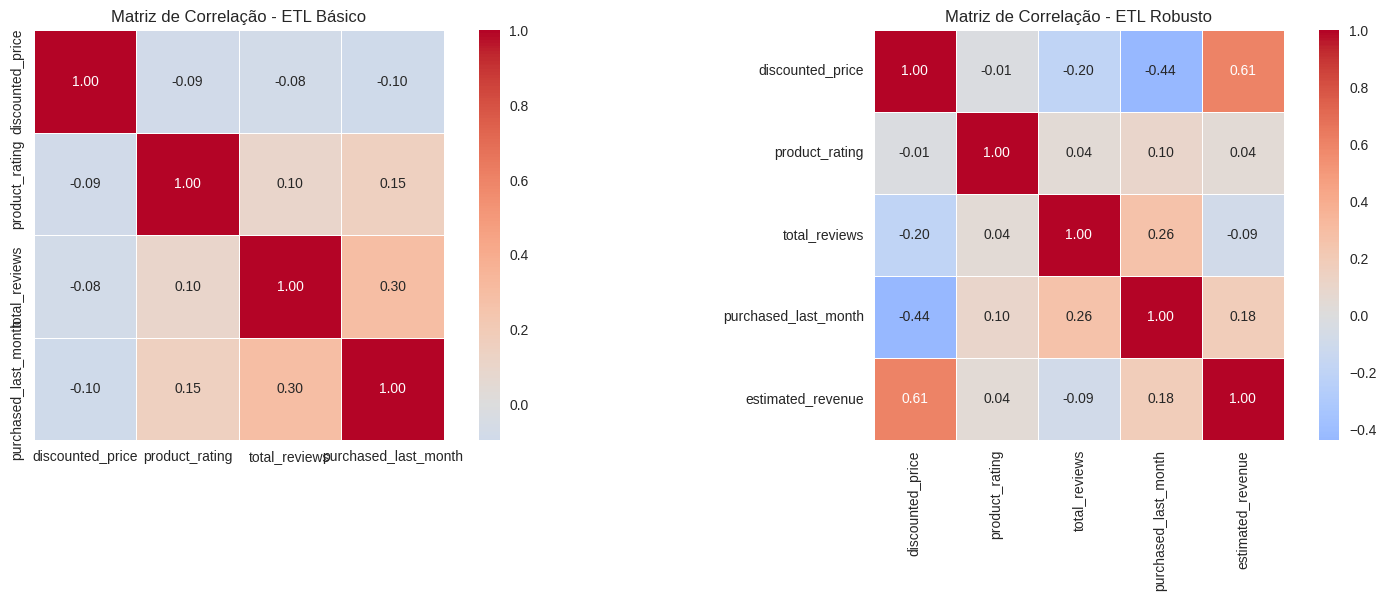

Correlações com Vendas Mensais - COMPARAÇÃO:
                      ETL_Básico  ETL_Robusto  Diferença
discounted_price          -0.096       -0.440     -0.344
estimated_revenue            NaN        0.179        NaN
product_rating             0.152        0.097     -0.055
purchased_last_month       1.000        1.000      0.000
total_reviews              0.296        0.262     -0.034


In [53]:
# ANÁLISE DE CORRELAÇÕES COMPARATIVA
print("=== ANÁLISE DE CORRELAÇÕES COMPARATIVA ===")

# Correlações ETL Básico
numeric_cols_basic = ['discounted_price', 'product_rating', 'total_reviews', 'purchased_last_month']
correlation_matrix_basic = df_basic[numeric_cols_basic].corr()

# Correlações ETL Robusto
numeric_cols_robust = ['discounted_price', 'product_rating', 'total_reviews', 'purchased_last_month', 'estimated_revenue']
correlation_matrix_robust = df_robust[numeric_cols_robust].corr()

# Visualização comparativa
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ETL Básico
sns.heatmap(correlation_matrix_basic, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, fmt='.2f', ax=axes[0])
axes[0].set_title('Matriz de Correlação - ETL Básico')

# ETL Robusto
sns.heatmap(correlation_matrix_robust, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, fmt='.2f', ax=axes[1])
axes[1].set_title('Matriz de Correlação - ETL Robusto')

plt.tight_layout()
plt.show()

# Comparação numérica das correlações
print("Correlações com Vendas Mensais - COMPARAÇÃO:")
corr_basic = correlation_matrix_basic['purchased_last_month']
corr_robust = correlation_matrix_robust['purchased_last_month']

corr_comparison = pd.DataFrame({
    'ETL_Básico': corr_basic,
    'ETL_Robusto': corr_robust,
    'Diferença': corr_robust - corr_basic
})
print(corr_comparison.round(3))

=== ANÁLISE DE CATEGORIAS COMPARATIVA ===
TOP 5 CATEGORIAS POR VENDAS - ETL BÁSICO:
  1. Power & Batteries: 26,151,450 vendas
  2. Phones: 3,729,550 vendas
  3. Other Electronics: 3,425,800 vendas
  4. Laptops: 3,416,450 vendas
  5. Cameras: 835,300 vendas

TOP 5 CATEGORIAS POR VENDAS - ETL ROBUSTO:
  1. Other Electronics: 1,283,650 vendas
  2. Phones: 835,500 vendas
  3. Laptops: 709,650 vendas
  4. TV & Display: 407,450 vendas
  5. Cameras: 338,800 vendas


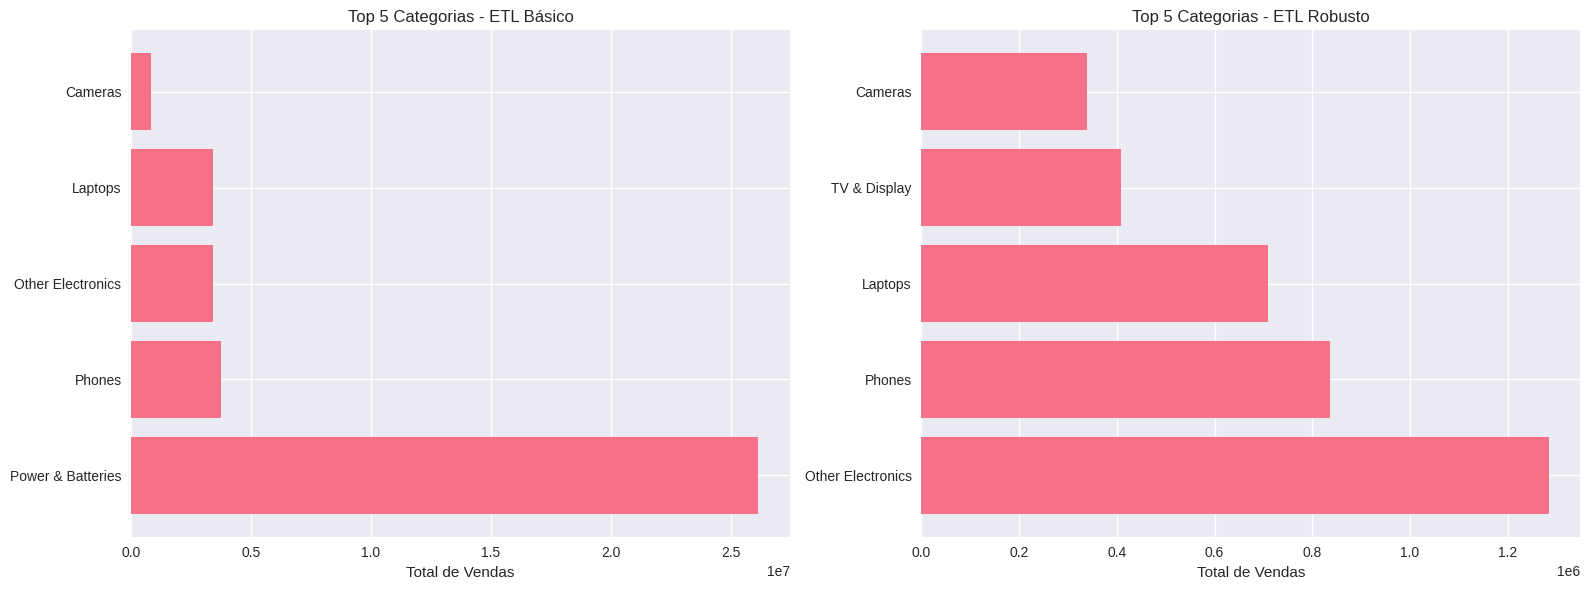

In [54]:
# ANÁLISE DE CATEGORIAS COMPARATIVA
print("=== ANÁLISE DE CATEGORIAS COMPARATIVA ===")

if 'product_category' in df_basic.columns and 'product_category' in df_robust.columns:

    # ETL Básico
    category_basic = df_basic.groupby('product_category').agg({
        'purchased_last_month': 'sum',
        'discounted_price': 'mean'
    }).round(2)

    # ETL Robusto
    category_robust = df_robust.groupby('product_category').agg({
        'purchased_last_month': 'sum',
        'discounted_price': 'mean',
        'estimated_revenue': 'sum'
    }).round(2)

    # Top 5 categorias por vendas - comparação
    top5_basic = category_basic.nlargest(5, 'purchased_last_month')
    top5_robust = category_robust.nlargest(5, 'purchased_last_month')

    print("TOP 5 CATEGORIAS POR VENDAS - ETL BÁSICO:")
    for i, (cat, row) in enumerate(top5_basic.iterrows(), 1):
        print(f"  {i}. {cat}: {row['purchased_last_month']:,.0f} vendas")

    print("\nTOP 5 CATEGORIAS POR VENDAS - ETL ROBUSTO:")
    for i, (cat, row) in enumerate(top5_robust.iterrows(), 1):
        print(f"  {i}. {cat}: {row['purchased_last_month']:,.0f} vendas")

    # Visualização comparativa
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # ETL Básico
    axes[0].barh(range(len(top5_basic)), top5_basic['purchased_last_month'])
    axes[0].set_yticks(range(len(top5_basic)))
    axes[0].set_yticklabels(top5_basic.index)
    axes[0].set_title('Top 5 Categorias - ETL Básico')
    axes[0].set_xlabel('Total de Vendas')

    # ETL Robusto
    axes[1].barh(range(len(top5_robust)), top5_robust['purchased_last_month'])
    axes[1].set_yticks(range(len(top5_robust)))
    axes[1].set_yticklabels(top5_robust.index)
    axes[1].set_title('Top 5 Categorias - ETL Robusto')
    axes[1].set_xlabel('Total de Vendas')

    plt.tight_layout()
    plt.show()

=== ANÁLISE DE PREÇOS COMPARATIVA ===
ANÁLISE POR CATEGORIA DE PREÇO - ETL BÁSICO:
                 purchased_last_month                     
                                count     mean         sum
discounted_price                                          
Muito Baixo                     12711  2812.07  35744250.0
Baixo                            4962   417.17   2070000.0
Médio                            6040   365.72   2208950.0
Alto                             4705   152.51    717550.0
Muito Alto                       1465   118.46    173550.0
Premium                           421    85.99     36200.0

ANÁLISE POR CATEGORIA DE PREÇO - ETL ROBUSTO:
               purchased_last_month                    estimated_revenue
                              count    mean        sum               sum
price_category                                                          
Muito Baixo                   10094  252.54  2549100.0        65792145.5
Baixo                          5178  172.49   8

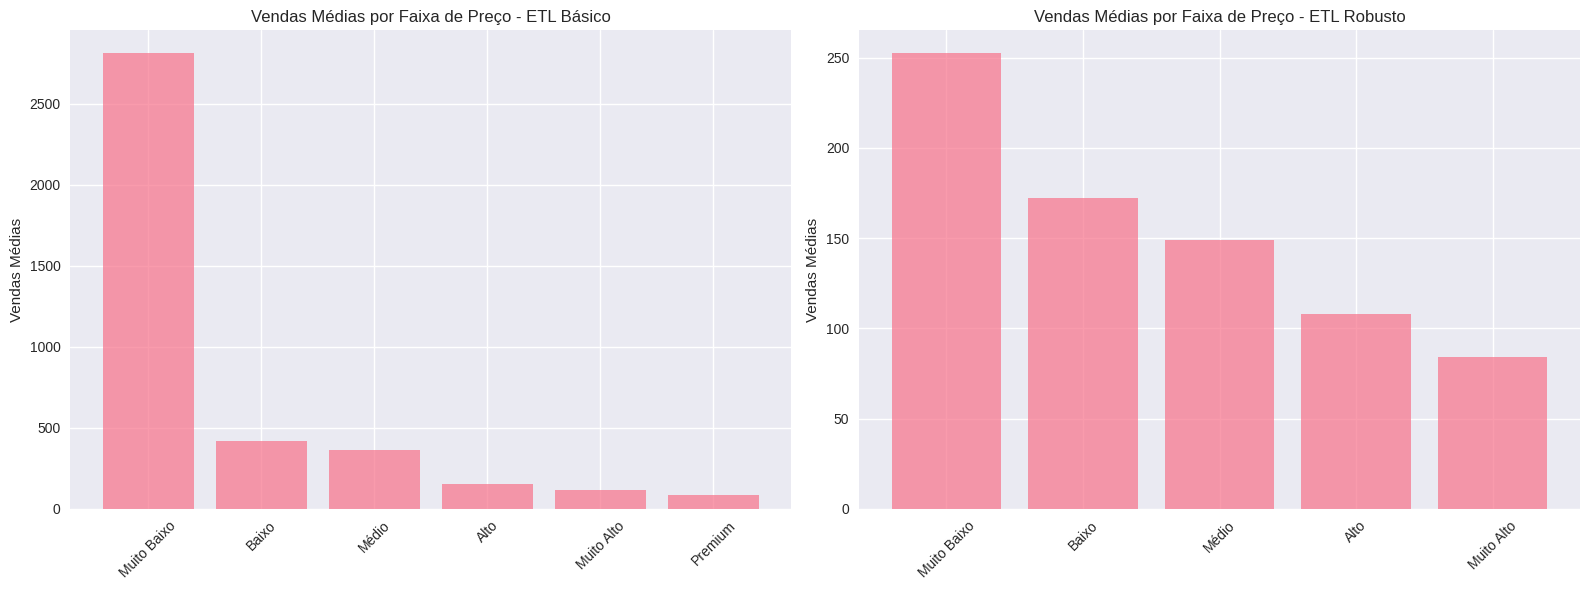

In [55]:
# ANÁLISE DE PREÇOS COMPARATIVA
print("=== ANÁLISE DE PREÇOS COMPARATIVA ===")

# ETL Básico - criar categorias de preço
price_bins = [0, 50, 100, 200, 500, 1000, float('inf')]
price_labels = ['Muito Baixo', 'Baixo', 'Médio', 'Alto', 'Muito Alto', 'Premium']

df_basic_price_cat = pd.cut(df_basic['discounted_price'], bins=price_bins, labels=price_labels)
price_analysis_basic = df_basic.groupby(df_basic_price_cat).agg({
    'purchased_last_month': ['count', 'mean', 'sum']
}).round(2)

# ETL Robusto - já tem a categoria criada
price_analysis_robust = df_robust.groupby('price_category').agg({
    'purchased_last_month': ['count', 'mean', 'sum'],
    'estimated_revenue': 'sum'
}).round(2)

print("ANÁLISE POR CATEGORIA DE PREÇO - ETL BÁSICO:")
print(price_analysis_basic)

print("\nANÁLISE POR CATEGORIA DE PREÇO - ETL ROBUSTO:")
print(price_analysis_robust)

# Visualização comparativa
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Vendas médias - ETL Básico
if 'mean' in price_analysis_basic['purchased_last_month']:
    axes[0].bar(price_analysis_basic.index, price_analysis_basic['purchased_last_month']['mean'], alpha=0.7)
    axes[0].set_title('Vendas Médias por Faixa de Preço - ETL Básico')
    axes[0].set_ylabel('Vendas Médias')
    axes[0].tick_params(axis='x', rotation=45)

# Vendas médias - ETL Robusto
if 'mean' in price_analysis_robust['purchased_last_month']:
    axes[1].bar(price_analysis_robust.index, price_analysis_robust['purchased_last_month']['mean'], alpha=0.7)
    axes[1].set_title('Vendas Médias por Faixa de Preço - ETL Robusto')
    axes[1].set_ylabel('Vendas Médias')
    axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [56]:
# ANÁLISE FINAL COMPARATIVA SIDE-BY-SIDE PROFISSIONAL
print("=== ANALISE COMPARATIVA: ETL BASICO vs ETL ROBUSTO ===")

def detailed_comparison_analysis(df_basic, df_robust):
    print("\n" + "="*100)
    print("COMPARACAO DETALHADA - METRICAS DE QUALIDADE E NEGOCIO")
    print("="*100)

    # METRICAS DE QUALIDADE DOS DADOS
    print("\nMETRICAS DE QUALIDADE DOS DADOS")
    print("-" * 80)

    quality_metrics = {
        'Metrica': [
            'Total de Registros',
            'Colunas Disponiveis',
            'Registros Duplicados',
            'Valores Missing Totais',
            'Taxa de Missing',
            'Completude dos Dados'
        ],
        'ETL_Basico': [
            len(df_basic),
            df_basic.shape[1],
            df_basic.duplicated().sum(),
            df_basic.isna().sum().sum(),
            f"{(df_basic.isna().sum().sum() / (len(df_basic) * df_basic.shape[1]) * 100):.1f}%",
            f"{((1 - (df_basic.isna().sum().sum() / (len(df_basic) * df_basic.shape[1]))) * 100):.1f}%"
        ],
        'ETL_Robusto': [
            len(df_robust),
            df_robust.shape[1],
            df_robust.duplicated().sum(),
            df_robust.isna().sum().sum(),
            f"{(df_robust.isna().sum().sum() / (len(df_robust) * df_robust.shape[1]) * 100):.1f}%",
            f"{((1 - (df_robust.isna().sum().sum() / (len(df_robust) * df_robust.shape[1]))) * 100):.1f}%"
        ],
        'Impacto': [
            f"{((len(df_robust)-len(df_basic))/len(df_basic)*100):+.1f}%",
            f"{df_robust.shape[1] - df_basic.shape[1]:+d}",
            f"{df_robust.duplicated().sum() - df_basic.duplicated().sum():+d}",
            f"{((df_robust.isna().sum().sum()-df_basic.isna().sum().sum())/df_basic.isna().sum().sum()*100):+.1f}%",
            f"{((df_robust.isna().sum().sum()/(len(df_robust)*df_robust.shape[1]) - df_basic.isna().sum().sum()/(len(df_basic)*df_basic.shape[1]))*100):+.1f}%",
            f"{((1 - (df_robust.isna().sum().sum()/(len(df_robust)*df_robust.shape[1])) - (1 - (df_basic.isna().sum().sum()/(len(df_basic)*df_basic.shape[1]))))*100):+.1f}%"
        ]
    }

    quality_df = pd.DataFrame(quality_metrics)
    print(quality_df.to_string(index=False))

    # METRICAS DE NEGOCIO COMPARATIVAS
    print("\nMETRICAS DE NEGOCIO COMPARATIVAS")
    print("-" * 80)

    # Calcular metricas de negocio
    basic_sales_total = df_basic['purchased_last_month'].sum()
    robust_sales_total = df_robust['purchased_last_month'].sum()
    basic_sales_mean = df_basic['purchased_last_month'].mean()
    robust_sales_mean = df_robust['purchased_last_month'].mean()
    basic_price_mean = df_basic['discounted_price'].mean()
    robust_price_mean = df_robust['discounted_price'].mean()
    basic_rating_mean = df_basic['product_rating'].mean()
    robust_rating_mean = df_robust['product_rating'].mean()

    # Calcular receita para ETL robusto
    if 'estimated_revenue' in df_robust.columns:
        robust_revenue = df_robust['estimated_revenue'].sum()
    else:
        robust_revenue = (df_robust['discounted_price'] * df_robust['purchased_last_month']).sum()

    basic_revenue = (df_basic['discounted_price'] * df_basic['purchased_last_month']).sum()

    # Calcular variabilidade (Coeficiente de Variacao)
    basic_cv = (df_basic['purchased_last_month'].std() / df_basic['purchased_last_month'].mean()) * 100
    robust_cv = (df_robust['purchased_last_month'].std() / df_robust['purchased_last_month'].mean()) * 100

    business_metrics = {
        'Metrica': [
            'Vendas Totais',
            'Vendas Medias por Produto',
            'Preco Medio',
            'Rating Medio',
            'Receita Total Estimada',
            'Variabilidade das Vendas (CV)'
        ],
        'ETL_Basico': [
            f"{basic_sales_total:,.0f}",
            f"{basic_sales_mean:.1f}",
            f"${basic_price_mean:.2f}",
            f"{basic_rating_mean:.2f}",
            f"${basic_revenue:,.0f}",
            f"{basic_cv:.1f}%"
        ],
        'ETL_Robusto': [
            f"{robust_sales_total:,.0f}",
            f"{robust_sales_mean:.1f}",
            f"${robust_price_mean:.2f}",
            f"{robust_rating_mean:.2f}",
            f"${robust_revenue:,.0f}",
            f"{robust_cv:.1f}%"
        ],
        'Diferenca': [
            f"{((robust_sales_total - basic_sales_total) / basic_sales_total * 100):+.1f}%",
            f"{((robust_sales_mean - basic_sales_mean) / basic_sales_mean * 100):+.1f}%",
            f"{((robust_price_mean - basic_price_mean) / basic_price_mean * 100):+.1f}%",
            f"{(robust_rating_mean - basic_rating_mean):+.2f}",
            f"{((robust_revenue - basic_revenue) / basic_revenue * 100):+.1f}%",
            f"{(robust_cv - basic_cv):+.1f}%"
        ]
    }

    business_df = pd.DataFrame(business_metrics)
    print(business_df.to_string(index=False))

    return quality_df, business_df

# Executar analise comparativa
quality_comparison, business_comparison = detailed_comparison_analysis(df_basic, df_robust)

=== ANALISE COMPARATIVA: ETL BASICO vs ETL ROBUSTO ===

COMPARACAO DETALHADA - METRICAS DE QUALIDADE E NEGOCIO

METRICAS DE QUALIDADE DOS DADOS
--------------------------------------------------------------------------------
               Metrica ETL_Basico ETL_Robusto Impacto
    Total de Registros      42675       27080  -36.5%
   Colunas Disponiveis         17          23      +6
  Registros Duplicados          0           0      +0
Valores Missing Totais      86717       41789  -51.8%
       Taxa de Missing      12.0%        6.7%   -5.2%
  Completude dos Dados      88.0%       93.3%   +5.2%

METRICAS DE NEGOCIO COMPARATIVAS
--------------------------------------------------------------------------------
                      Metrica     ETL_Basico  ETL_Robusto Diferenca
                Vendas Totais     41,609,450    4,969,450    -88.1%
    Vendas Medias por Produto         1293.7        183.5    -85.8%
                  Preco Medio        $243.23      $125.53    -48.4%
          

In [57]:
# ANALISE DE CORRELACOES COMPARATIVA DETALHADA
print("\n" + "="*100)
print("ANALISE DE CORRELACOES COMPARATIVA")
print("="*100)

# Calcular correlacoes para ambos os datasets
correlation_vars = ['discounted_price', 'product_rating', 'total_reviews', 'purchased_last_month']

corr_basic = df_basic[correlation_vars].corr()['purchased_last_month']
corr_robust = df_robust[correlation_vars].corr()['purchased_last_month']

print("\nCORRELACOES COM VENDAS MENSASIS")
print("-" * 60)
correlation_comparison = pd.DataFrame({
    'Variavel': correlation_vars,
    'ETL_Basico': [f"{corr:.3f}" for corr in corr_basic.values],
    'ETL_Robusto': [f"{corr:.3f}" for corr in corr_robust.values],
    'Mudanca': [f"{(corr_robust.values[i] - corr_basic.values[i]):+.3f}" for i in range(len(correlation_vars))]
})

print(correlation_comparison.to_string(index=False))

# Analise de significancia das correlacoes
print("\nINTERPRETACAO DAS CORRELACOES:")
for i, var in enumerate(correlation_vars):
    if var != 'purchased_last_month':
        basic_corr = corr_basic.values[i]
        robust_corr = corr_robust.values[i]
        change = robust_corr - basic_corr

        # Classificar forca da correlacao
        def classify_correlation(corr):
            abs_corr = abs(corr)
            if abs_corr >= 0.7:
                return "muito forte"
            elif abs_corr >= 0.5:
                return "forte"
            elif abs_corr >= 0.3:
                return "moderada"
            elif abs_corr >= 0.1:
                return "fraca"
            else:
                return "muito fraca"

        basic_strength = classify_correlation(basic_corr)
        robust_strength = classify_correlation(robust_corr)
        direction = "positiva" if robust_corr > 0 else "negativa"

        print(f"{var}:")
        print(f"  ETL Basico: {basic_corr:.3f} ({basic_strength})")
        print(f"  ETL Robusto: {robust_corr:.3f} ({robust_strength}, {direction})")
        print(f"  Mudanca: {change:+.3f}")


ANALISE DE CORRELACOES COMPARATIVA

CORRELACOES COM VENDAS MENSASIS
------------------------------------------------------------
            Variavel ETL_Basico ETL_Robusto Mudanca
    discounted_price     -0.096      -0.440  -0.344
      product_rating      0.152       0.097  -0.055
       total_reviews      0.296       0.262  -0.034
purchased_last_month      1.000       1.000  +0.000

INTERPRETACAO DAS CORRELACOES:
discounted_price:
  ETL Basico: -0.096 (muito fraca)
  ETL Robusto: -0.440 (moderada, negativa)
  Mudanca: -0.344
product_rating:
  ETL Basico: 0.152 (fraca)
  ETL Robusto: 0.097 (muito fraca, positiva)
  Mudanca: -0.055
total_reviews:
  ETL Basico: 0.296 (fraca)
  ETL Robusto: 0.262 (fraca, positiva)
  Mudanca: -0.034


In [58]:
# ANALISE DE CATEGORIAS COMPARATIVA DETALHADA
print("\n" + "="*100)
print("ANALISE DE CATEGORIAS POR DESEMPENHO")
print("="*100)

if 'product_category' in df_basic.columns and 'product_category' in df_robust.columns:

    # Top categorias por vendas totais
    top_categories_basic = df_basic.groupby('product_category')['purchased_last_month'].sum().nlargest(5)
    top_categories_robust = df_robust.groupby('product_category')['purchased_last_month'].sum().nlargest(5)

    print("\nTOP 5 CATEGORIAS POR VENDAS TOTAIS")
    print("-" * 50)
    print("ETL BASICO:")
    for i, (category, sales) in enumerate(top_categories_basic.items(), 1):
        market_share = (sales / top_categories_basic.sum()) * 100
        print(f"  {i}. {category}: {sales:,.0f} vendas ({market_share:.1f}%)")

    print("\nETL ROBUSTO:")
    for i, (category, sales) in enumerate(top_categories_robust.items(), 1):
        market_share = (sales / top_categories_robust.sum()) * 100
        print(f"  {i}. {category}: {sales:,.0f} vendas ({market_share:.1f}%)")

    # Analise de consistencia entre rankings
    common_categories = set(top_categories_basic.index) & set(top_categories_robust.index)
    print(f"\nCATEGORIAS COMUNS NO TOP 5: {len(common_categories)}")

    # Categorias que entraram/sairam do top 5
    entered_top = set(top_categories_robust.index) - set(top_categories_basic.index)
    left_top = set(top_categories_basic.index) - set(top_categories_robust.index)

    if entered_top:
        print("CATEGORIAS QUE ENTRARAM NO TOP 5 NO ETL ROBUSTO:")
        for cat in entered_top:
            print(f"  - {cat}")

    if left_top:
        print("CATEGORIAS QUE SAIRAM DO TOP 5 NO ETL ROBUSTO:")
        for cat in left_top:
            print(f"  - {cat}")


ANALISE DE CATEGORIAS POR DESEMPENHO

TOP 5 CATEGORIAS POR VENDAS TOTAIS
--------------------------------------------------
ETL BASICO:
  1. Power & Batteries: 26,151,450 vendas (69.6%)
  2. Phones: 3,729,550 vendas (9.9%)
  3. Other Electronics: 3,425,800 vendas (9.1%)
  4. Laptops: 3,416,450 vendas (9.1%)
  5. Cameras: 835,300 vendas (2.2%)

ETL ROBUSTO:
  1. Other Electronics: 1,283,650 vendas (35.9%)
  2. Phones: 835,500 vendas (23.4%)
  3. Laptops: 709,650 vendas (19.9%)
  4. TV & Display: 407,450 vendas (11.4%)
  5. Cameras: 338,800 vendas (9.5%)

CATEGORIAS COMUNS NO TOP 5: 4
CATEGORIAS QUE ENTRARAM NO TOP 5 NO ETL ROBUSTO:
  - TV & Display
CATEGORIAS QUE SAIRAM DO TOP 5 NO ETL ROBUSTO:
  - Power & Batteries


In [59]:
# ANALISE DE ESTRATEGIA DE PRECOS COMPARATIVA
print("\n" + "="*100)
print("ANALISE DE ESTRATEGIA DE PRECOS")
print("="*100)

# Definir faixas de preco consistentes
price_bins = [0, 50, 100, 200, 500, 1000, float('inf')]
price_labels = ['Muito Baixo', 'Baixo', 'Medio', 'Alto', 'Muito Alto', 'Premium']

# ETL Basico
df_basic_price_cat = pd.cut(df_basic['discounted_price'], bins=price_bins, labels=price_labels)
price_performance_basic = df_basic.groupby(df_basic_price_cat).agg({
    'purchased_last_month': ['count', 'mean', 'sum']
}).round(2)

# ETL Robusto
price_performance_robust = df_robust.groupby('price_category').agg({
    'purchased_last_month': ['count', 'mean', 'sum'],
    'estimated_revenue': 'sum'
}).round(2)

print("\nDESEMPENHO POR FAIXA DE PRECO")
print("-" * 70)

for price_cat in price_labels:
    if price_cat in price_performance_basic.index and price_cat in price_performance_robust.index:
        basic_mean = price_performance_basic.loc[price_cat, ('purchased_last_month', 'mean')]
        robust_mean = price_performance_robust.loc[price_cat, ('purchased_last_month', 'mean')]
        basic_count = price_performance_basic.loc[price_cat, ('purchased_last_month', 'count')]
        robust_count = price_performance_robust.loc[price_cat, ('purchased_last_month', 'count')]

        change_mean = ((robust_mean - basic_mean) / basic_mean * 100) if basic_mean > 0 else 0
        change_count = ((robust_count - basic_count) / basic_count * 100) if basic_count > 0 else 0

        print(f"{price_cat}:")
        print(f"  Vendas medias: {basic_mean:.1f} -> {robust_mean:.1f} ({change_mean:+.1f}%)")
        print(f"  Numero de produtos: {basic_count} -> {robust_count} ({change_count:+.1f}%)")

# Identificar faixa de preco otima
best_price_basic = price_performance_basic[('purchased_last_month', 'mean')].idxmax()
best_price_robust = price_performance_robust[('purchased_last_month', 'mean')].idxmax()

print(f"\nFAIXA DE PRECO COM MELHOR PERFORMANCE:")
print(f"  ETL Basico: {best_price_basic}")
print(f"  ETL Robusto: {best_price_robust}")
print(f"  Consistente: {'SIM' if best_price_basic == best_price_robust else 'NAO'}")


ANALISE DE ESTRATEGIA DE PRECOS

DESEMPENHO POR FAIXA DE PRECO
----------------------------------------------------------------------
Muito Baixo:
  Vendas medias: 2812.1 -> 252.5 (-91.0%)
  Numero de produtos: 12711 -> 10094 (-20.6%)
Baixo:
  Vendas medias: 417.2 -> 172.5 (-58.7%)
  Numero de produtos: 4962 -> 5178 (+4.4%)
Alto:
  Vendas medias: 152.5 -> 108.2 (-29.0%)
  Numero de produtos: 4705 -> 5702 (+21.2%)
Muito Alto:
  Vendas medias: 118.5 -> 84.2 (-28.9%)
  Numero de produtos: 1465 -> 19 (-98.7%)
Premium:
  Vendas medias: 86.0 -> nan (+nan%)
  Numero de produtos: 421 -> 0 (-100.0%)

FAIXA DE PRECO COM MELHOR PERFORMANCE:
  ETL Basico: Muito Baixo
  ETL Robusto: Muito Baixo
  Consistente: SIM


In [62]:
# ANALISE DE IMPACTO DA QUALIDADE DOS PRODUTOS (CORRIGIDA)
print("\n" + "="*100)
print("ANALISE DE IMPACTO DA QUALIDADE DOS PRODUTOS")
print("="*100)

# Definir categorias de rating consistentes
rating_bins = [0, 3, 4, 4.5, 5]
rating_labels = ['Ruim', 'Regular', 'Bom', 'Excelente']

# ETL Basico
df_basic_rating_cat = pd.cut(df_basic['product_rating'], bins=rating_bins, labels=rating_labels)
rating_impact_basic = df_basic.groupby(df_basic_rating_cat).agg({
    'purchased_last_month': ['count', 'mean', 'sum']
}).round(2)

# ETL Robusto - usar a categoria ja criada ou criar se necessario
if 'rating_category' not in df_robust.columns:
    df_robust['rating_category'] = pd.cut(df_robust['product_rating'], bins=rating_bins, labels=rating_labels)

rating_impact_robust = df_robust.groupby('rating_category').agg({
    'purchased_last_month': ['count', 'mean', 'sum'],
    'discounted_price': 'mean'
}).round(2)

print("\nIMPACTO DO RATING NAS VENDAS")
print("-" * 60)

for rating_cat in rating_labels:
    if rating_cat in rating_impact_basic.index and rating_cat in rating_impact_robust.index:
        basic_sales = rating_impact_basic.loc[rating_cat, ('purchased_last_month', 'mean')]
        robust_sales = rating_impact_robust.loc[rating_cat, ('purchased_last_month', 'mean')]

        # Calcular preco medio manualmente para evitar erro de formato
        basic_price_data = df_basic[df_basic_rating_cat == rating_cat]['discounted_price']
        robust_price_data = df_robust[df_robust['rating_category'] == rating_cat]['discounted_price']

        basic_price = basic_price_data.mean() if len(basic_price_data) > 0 else 0
        robust_price = robust_price_data.mean() if len(robust_price_data) > 0 else 0

        sales_change = ((robust_sales - basic_sales) / basic_sales * 100) if basic_sales > 0 else 0
        price_change = ((robust_price - basic_price) / basic_price * 100) if basic_price > 0 else 0

        print(f"{rating_cat}:")
        print(f"  Vendas medias: {basic_sales:.1f} -> {robust_sales:.1f} ({sales_change:+.1f}%)")
        print(f"  Preco medio: ${basic_price:.2f} -> ${robust_price:.2f} ({price_change:+.1f}%)")

# Calcular premio de qualidade
best_rating_basic = rating_impact_basic[('purchased_last_month', 'mean')].idxmax()
worst_rating_basic = rating_impact_basic[('purchased_last_month', 'mean')].idxmin()
quality_premium_basic = (rating_impact_basic.loc[best_rating_basic, ('purchased_last_month', 'mean')] /
                        rating_impact_basic.loc[worst_rating_basic, ('purchased_last_month', 'mean')] - 1) * 100

best_rating_robust = rating_impact_robust[('purchased_last_month', 'mean')].idxmax()
worst_rating_robust = rating_impact_robust[('purchased_last_month', 'mean')].idxmin()
quality_premium_robust = (rating_impact_robust.loc[best_rating_robust, ('purchased_last_month', 'mean')] /
                         rating_impact_robust.loc[worst_rating_robust, ('purchased_last_month', 'mean')] - 1) * 100

print(f"\nPREMIO POR QUALIDADE (vendas do melhor vs pior rating):")
print(f"  ETL Basico: {best_rating_basic} vende {quality_premium_basic:.1f}% mais que {worst_rating_basic}")
print(f"  ETL Robusto: {best_rating_robust} vende {quality_premium_robust:.1f}% mais que {worst_rating_robust}")

# Analise adicional: Distribuicao de produtos por categoria de rating
print(f"\nDISTRIBUICAO DE PRODUTOS POR CATEGORIA DE RATING")
print("-" * 50)

for rating_cat in rating_labels:
    if rating_cat in rating_impact_basic.index and rating_cat in rating_impact_robust.index:
        basic_count = rating_impact_basic.loc[rating_cat, ('purchased_last_month', 'count')]
        robust_count = rating_impact_robust.loc[rating_cat, ('purchased_last_month', 'count')]

        basic_pct = (basic_count / len(df_basic)) * 100
        robust_pct = (robust_count / len(df_robust)) * 100
        count_change = ((robust_count - basic_count) / basic_count * 100) if basic_count > 0 else 0

        print(f"{rating_cat}:")
        print(f"  ETL Basico: {basic_count} produtos ({basic_pct:.1f}%)")
        print(f"  ETL Robusto: {robust_count} produtos ({robust_pct:.1f}%)")
        print(f"  Variacao: {count_change:+.1f}%")


ANALISE DE IMPACTO DA QUALIDADE DOS PRODUTOS

IMPACTO DO RATING NAS VENDAS
------------------------------------------------------------
Ruim:
  Vendas medias: 53.0 -> 136.4 (+157.3%)
  Preco medio: $1273.32 -> $191.84 (-84.9%)
Regular:
  Vendas medias: 187.2 -> 162.9 (-13.0%)
  Preco medio: $159.98 -> $122.72 (-23.3%)
Bom:
  Vendas medias: 430.9 -> 181.3 (-57.9%)
  Preco medio: $277.35 -> $135.31 (-51.2%)
Excelente:
  Vendas medias: 2487.6 -> 197.1 (-92.1%)
  Preco medio: $190.53 -> $112.67 (-40.9%)

PREMIO POR QUALIDADE (vendas do melhor vs pior rating):
  ETL Basico: Excelente vende 4593.6% mais que Ruim
  ETL Robusto: Excelente vende 44.6% mais que Ruim

DISTRIBUICAO DE PRODUTOS POR CATEGORIA DE RATING
--------------------------------------------------
Ruim:
  ETL Basico: 150 produtos (0.4%)
  ETL Robusto: 33 produtos (0.1%)
  Variacao: -78.0%
Regular:
  ETL Basico: 4148 produtos (9.7%)
  ETL Robusto: 4591 produtos (17.0%)
  Variacao: +10.7%
Bom:
  ETL Basico: 13765 produtos (32.3%


ANALISE DE SEGMENTACAO DE PRODUTOS COM VISUALIZACOES

SEGMENTOS DE PRODUTOS IDENTIFICADOS (ETL ROBUSTO)
------------------------------------------------------------


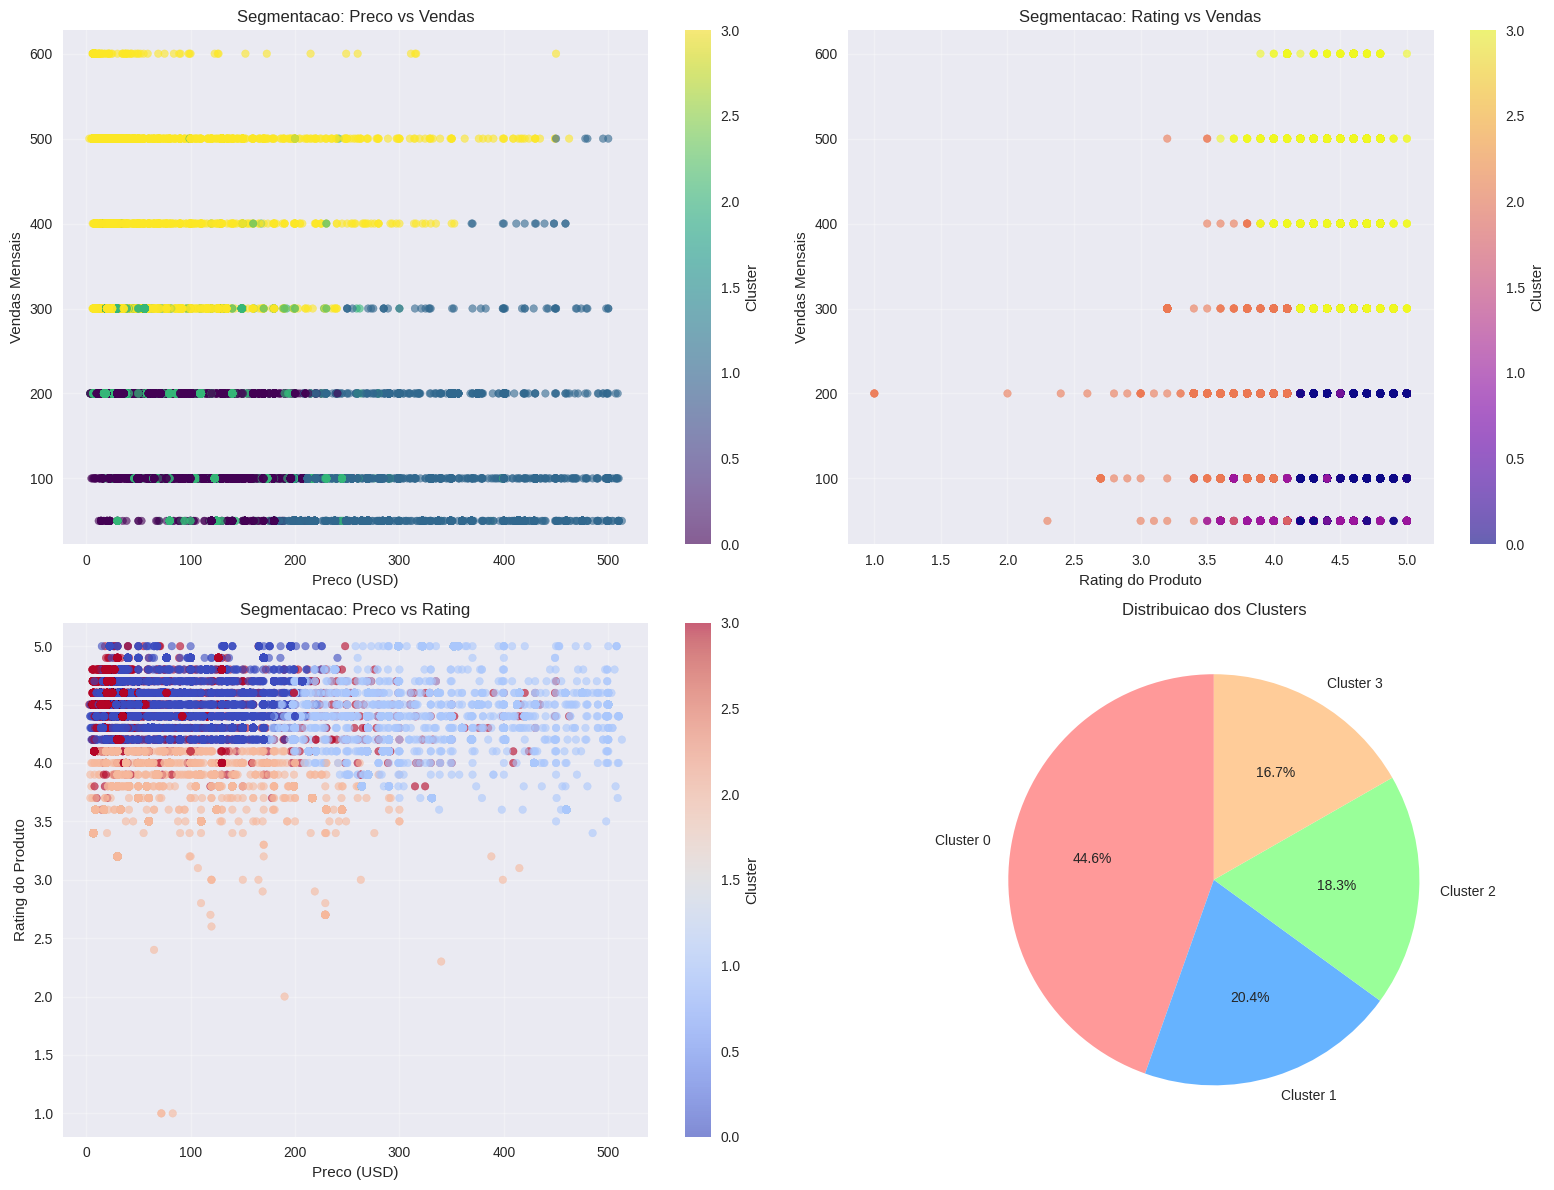

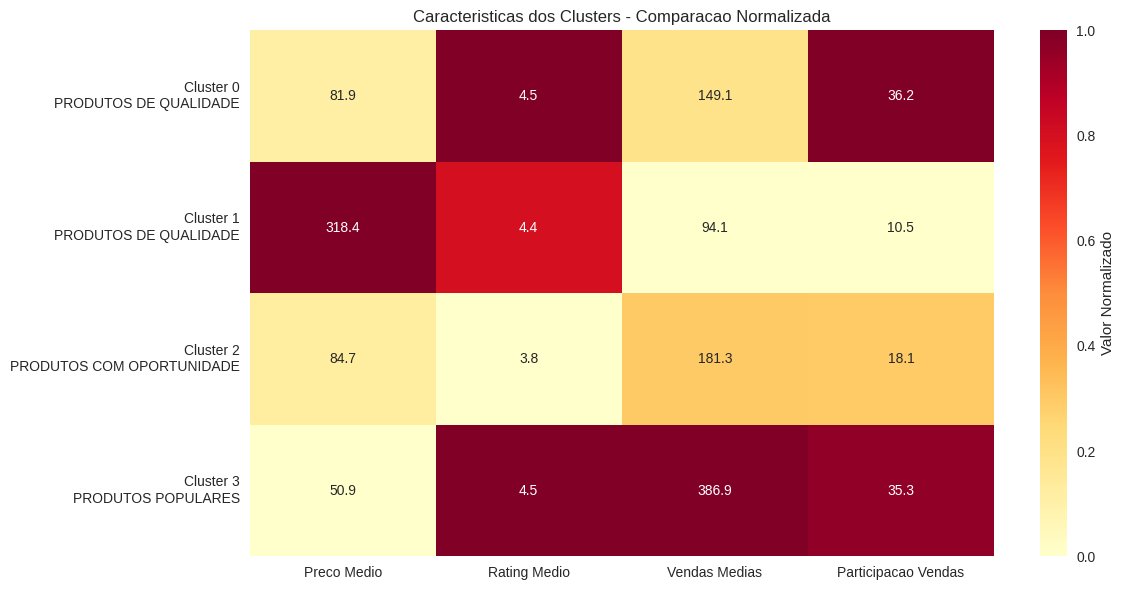

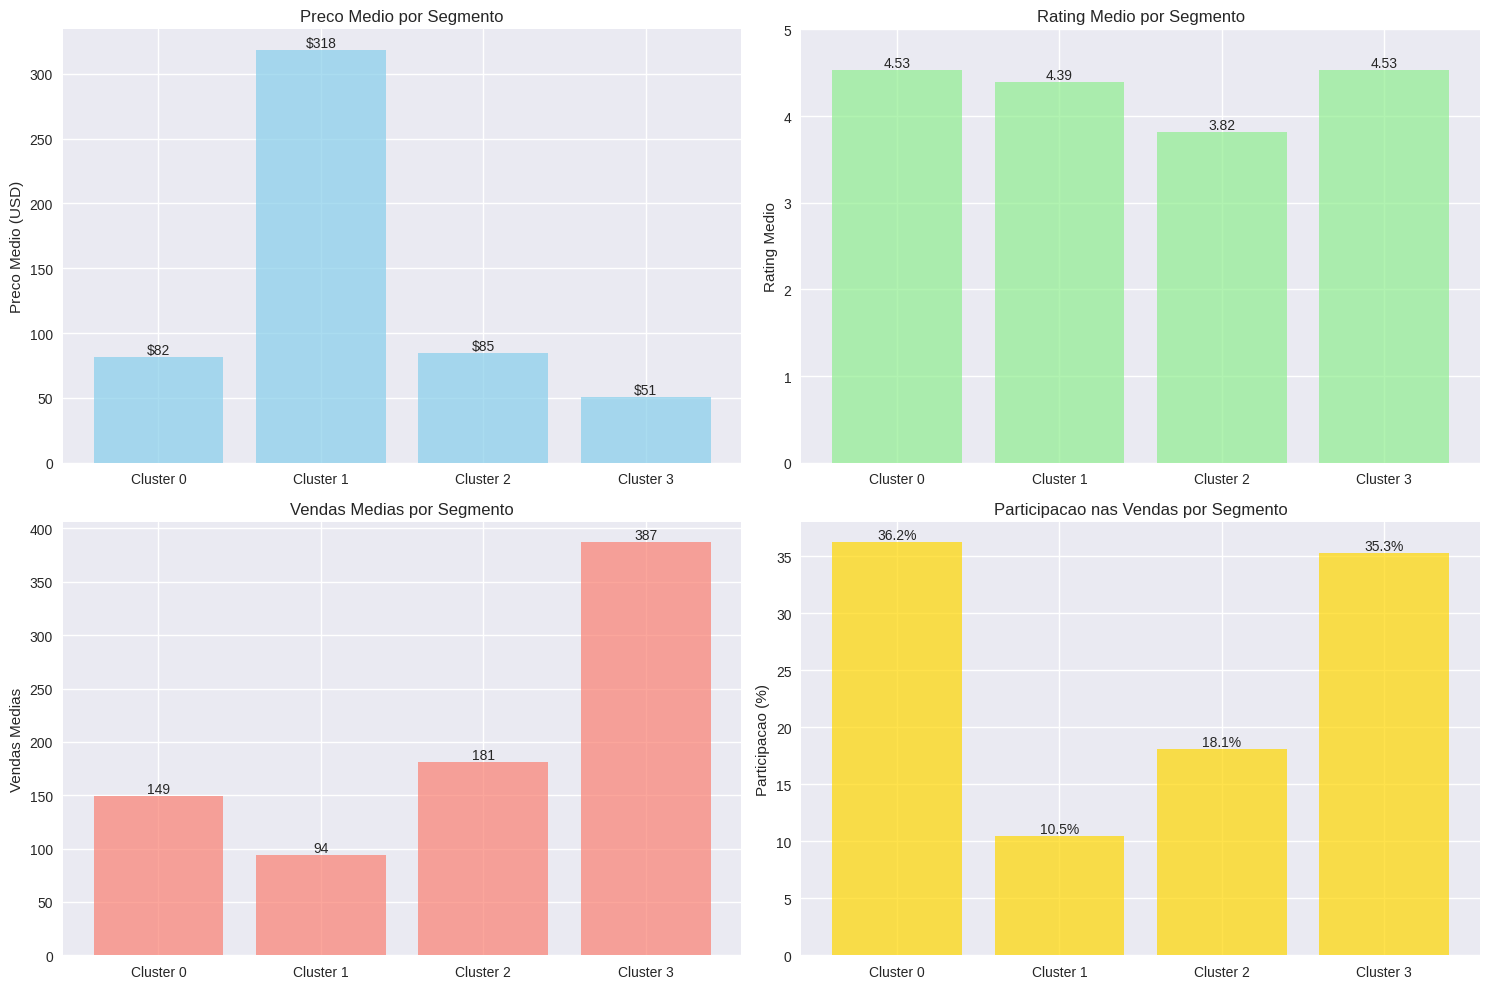


DETALHAMENTO DOS SEGMENTOS IDENTIFICADOS:
----------------------------------------------------------------------

SEGMENTO 0 - PRODUTOS DE QUALIDADE:
  Descricao: Alta satisfacao, potencial de crescimento
  Caracteristicas:
    • Preco medio: $81.88
    • Rating medio: 4.53/5
    • Vendas medias: 149.1 unidades
  Metricas de Mercado:
    • Quantidade de produtos: 12069 (44.6% do total)
    • Participacao nas vendas: 36.2%
  Estrategia Recomendada: Investir em marketing, aumentar visibilidade

SEGMENTO 3 - PRODUTOS POPULARES:
  Descricao: Preco competitivo, alta rotatividade
  Caracteristicas:
    • Preco medio: $50.94
    • Rating medio: 4.53/5
    • Vendas medias: 386.9 unidades
  Metricas de Mercado:
    • Quantidade de produtos: 4530 (16.7% do total)
    • Participacao nas vendas: 35.3%
  Estrategia Recomendada: Manter preco competitivo, focar em volume

SEGMENTO 2 - PRODUTOS COM OPORTUNIDADE:
  Descricao: Desempenho abaixo da media
  Caracteristicas:
    • Preco medio: $84.66
    

In [64]:
# ANALISE DE SEGMENTACAO E CLUSTERIZACAO COM VISUALIZACOES GRAFICAS
print("\n" + "="*100)
print("ANALISE DE SEGMENTACAO DE PRODUTOS COM VISUALIZACOES")
print("="*100)

# Executar clusterizacao para ETL Robusto
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

cluster_features = ['discounted_price', 'product_rating', 'purchased_last_month']
cluster_data_robust = df_robust[cluster_features].dropna()

if len(cluster_data_robust) > 100:
    scaler = StandardScaler()
    X_cluster = scaler.fit_transform(cluster_data_robust)

    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_cluster)

    cluster_data_robust = cluster_data_robust.copy()
    cluster_data_robust['cluster'] = clusters

    # Analise dos clusters - CORRECAO: usar .iloc[0] para obter valores escalares
    cluster_analysis = cluster_data_robust.groupby('cluster').agg({
        'discounted_price': 'mean',
        'product_rating': 'mean',
        'purchased_last_month': ['mean', 'count', 'sum']
    }).round(2)

    # Calcular metricas gerais para comparacao (valores escalares)
    avg_price = cluster_data_robust['discounted_price'].mean()
    avg_rating = cluster_data_robust['product_rating'].mean()
    avg_sales = cluster_data_robust['purchased_last_month'].mean()

    print("\nSEGMENTOS DE PRODUTOS IDENTIFICADOS (ETL ROBUSTO)")
    print("-" * 60)

    # Interpretar clusters CORRIGIDO
    segment_descriptions = {}
    total_products = len(cluster_data_robust)
    total_sales = cluster_data_robust['purchased_last_month'].sum()

    for cluster in cluster_analysis.index:
        # Obter valores escalares usando .iloc[0]
        price = float(cluster_analysis.loc[cluster, 'discounted_price'])
        rating = float(cluster_analysis.loc[cluster, 'product_rating'])
        sales_mean = float(cluster_analysis.loc[cluster, ('purchased_last_month', 'mean')])
        sales_count = int(cluster_analysis.loc[cluster, ('purchased_last_month', 'count')])
        sales_total = float(cluster_analysis.loc[cluster, ('purchased_last_month', 'sum')])

        # Calcular participacao
        product_share = (sales_count / total_products) * 100
        sales_share = (sales_total / total_sales) * 100

        # Classificar segmento baseado em caracteristicas (usando valores escalares)
        if price > avg_price and sales_mean > avg_sales:
            segment_type = "PRODUTOS PREMIUM"
            description = "Alto preco, alta performance de vendas"
            strategy = "Manter posicionamento premium, explorar upsell"
        elif price < avg_price and sales_mean > avg_sales:
            segment_type = "PRODUTOS POPULARES"
            description = "Preco competitivo, alta rotatividade"
            strategy = "Manter preco competitivo, focar em volume"
        elif rating > avg_rating and sales_mean < avg_sales:
            segment_type = "PRODUTOS DE QUALIDADE"
            description = "Alta satisfacao, potencial de crescimento"
            strategy = "Investir em marketing, aumentar visibilidade"
        else:
            segment_type = "PRODUTOS COM OPORTUNIDADE"
            description = "Desempenho abaixo da media"
            strategy = "Revisar estrategia, considerar reposicionamento"

        segment_descriptions[cluster] = {
            'tipo': segment_type,
            'descricao': description,
            'estrategia': strategy,
            'preco_medio': price,
            'rating_medio': rating,
            'vendas_medias': sales_mean,
            'quantidade': sales_count,
            'participacao_produtos': product_share,
            'participacao_vendas': sales_share
        }

    # VISUALIZACOES GRAFICAS DOS CLUSTERS

    # 1. Grafico de dispersao 3D (se possivel) ou 2D
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Grafico 1: Preco vs Vendas (colorido por cluster)
    scatter1 = axes[0,0].scatter(cluster_data_robust['discounted_price'],
                               cluster_data_robust['purchased_last_month'],
                               c=cluster_data_robust['cluster'],
                               cmap='viridis', alpha=0.6, s=30)
    axes[0,0].set_xlabel('Preco (USD)')
    axes[0,0].set_ylabel('Vendas Mensais')
    axes[0,0].set_title('Segmentacao: Preco vs Vendas')
    axes[0,0].grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=axes[0,0], label='Cluster')

    # Grafico 2: Rating vs Vendas (colorido por cluster)
    scatter2 = axes[0,1].scatter(cluster_data_robust['product_rating'],
                               cluster_data_robust['purchased_last_month'],
                               c=cluster_data_robust['cluster'],
                               cmap='plasma', alpha=0.6, s=30)
    axes[0,1].set_xlabel('Rating do Produto')
    axes[0,1].set_ylabel('Vendas Mensais')
    axes[0,1].set_title('Segmentacao: Rating vs Vendas')
    axes[0,1].grid(True, alpha=0.3)
    plt.colorbar(scatter2, ax=axes[0,1], label='Cluster')

    # Grafico 3: Preco vs Rating (colorido por cluster)
    scatter3 = axes[1,0].scatter(cluster_data_robust['discounted_price'],
                               cluster_data_robust['product_rating'],
                               c=cluster_data_robust['cluster'],
                               cmap='coolwarm', alpha=0.6, s=30)
    axes[1,0].set_xlabel('Preco (USD)')
    axes[1,0].set_ylabel('Rating do Produto')
    axes[1,0].set_title('Segmentacao: Preco vs Rating')
    axes[1,0].grid(True, alpha=0.3)
    plt.colorbar(scatter3, ax=axes[1,0], label='Cluster')

    # Grafico 4: Distribuicao dos clusters (pie chart)
    cluster_sizes = cluster_data_robust['cluster'].value_counts().sort_index()
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    axes[1,1].pie(cluster_sizes.values, labels=[f'Cluster {i}' for i in cluster_sizes.index],
                 autopct='%1.1f%%', colors=colors[:len(cluster_sizes)], startangle=90)
    axes[1,1].set_title('Distribuicao dos Clusters')

    plt.tight_layout()
    plt.show()

    # 2. Heatmap das caracteristicas dos clusters
    plt.figure(figsize=(12, 6))

    # Preparar dados para heatmap
    heatmap_data = []
    cluster_labels = []

    for cluster, info in segment_descriptions.items():
        heatmap_data.append([
            info['preco_medio'],
            info['rating_medio'],
            info['vendas_medias'],
            info['participacao_vendas']
        ])
        cluster_labels.append(f"Cluster {cluster}\n{info['tipo']}")

    heatmap_data = np.array(heatmap_data)

    # Normalizar dados para melhor visualizacao
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    heatmap_normalized = scaler.fit_transform(heatmap_data)

    # Criar heatmap
    sns.heatmap(heatmap_normalized,
                xticklabels=['Preco Medio', 'Rating Medio', 'Vendas Medias', 'Participacao Vendas'],
                yticklabels=cluster_labels,
                annot=heatmap_data,
                fmt='.1f',
                cmap='YlOrRd',
                cbar_kws={'label': 'Valor Normalizado'})

    plt.title('Caracteristicas dos Clusters - Comparacao Normalizada')
    plt.tight_layout()
    plt.show()

    # 3. Grafico de barras comparativo
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Barras: Preco medio por cluster
    clusters_sorted = sorted(segment_descriptions.keys())
    precios = [segment_descriptions[cluster]['preco_medio'] for cluster in clusters_sorted]
    ratings = [segment_descriptions[cluster]['rating_medio'] for cluster in clusters_sorted]
    vendas = [segment_descriptions[cluster]['vendas_medias'] for cluster in clusters_sorted]
    participacao = [segment_descriptions[cluster]['participacao_vendas'] for cluster in clusters_sorted]

    bars1 = axes[0,0].bar(range(len(clusters_sorted)), precios, color='skyblue', alpha=0.7)
    axes[0,0].set_title('Preco Medio por Segmento')
    axes[0,0].set_ylabel('Preco Medio (USD)')
    axes[0,0].set_xticks(range(len(clusters_sorted)))
    axes[0,0].set_xticklabels([f'Cluster {c}' for c in clusters_sorted])

    # Adicionar valores nas barras
    for bar, valor in zip(bars1, precios):
        axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'${valor:.0f}',
                      ha='center', va='bottom')

    # Barras: Rating medio por cluster
    bars2 = axes[0,1].bar(range(len(clusters_sorted)), ratings, color='lightgreen', alpha=0.7)
    axes[0,1].set_title('Rating Medio por Segmento')
    axes[0,1].set_ylabel('Rating Medio')
    axes[0,1].set_ylim(0, 5)
    axes[0,1].set_xticks(range(len(clusters_sorted)))
    axes[0,1].set_xticklabels([f'Cluster {c}' for c in clusters_sorted])

    for bar, valor in zip(bars2, ratings):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{valor:.2f}',
                      ha='center', va='bottom')

    # Barras: Vendas medias por cluster
    bars3 = axes[1,0].bar(range(len(clusters_sorted)), vendas, color='salmon', alpha=0.7)
    axes[1,0].set_title('Vendas Medias por Segmento')
    axes[1,0].set_ylabel('Vendas Medias')
    axes[1,0].set_xticks(range(len(clusters_sorted)))
    axes[1,0].set_xticklabels([f'Cluster {c}' for c in clusters_sorted])

    for bar, valor in zip(bars3, vendas):
        axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{valor:.0f}',
                      ha='center', va='bottom')

    # Barras: Participacao nas vendas
    bars4 = axes[1,1].bar(range(len(clusters_sorted)), participacao, color='gold', alpha=0.7)
    axes[1,1].set_title('Participacao nas Vendas por Segmento')
    axes[1,1].set_ylabel('Participacao (%)')
    axes[1,1].set_xticks(range(len(clusters_sorted)))
    axes[1,1].set_xticklabels([f'Cluster {c}' for c in clusters_sorted])

    for bar, valor in zip(bars4, participacao):
        axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{valor:.1f}%',
                      ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # APRESENTAR RESULTADOS DA SEGMENTACAO
    print("\nDETALHAMENTO DOS SEGMENTOS IDENTIFICADOS:")
    print("-" * 70)

    # Apresentar segmentos ordenados por participacao nas vendas
    sorted_segments = sorted(segment_descriptions.items(),
                           key=lambda x: x[1]['participacao_vendas'],
                           reverse=True)

    for cluster, info in sorted_segments:
        print(f"\nSEGMENTO {cluster} - {info['tipo']}:")
        print(f"  Descricao: {info['descricao']}")
        print(f"  Caracteristicas:")
        print(f"    • Preco medio: ${info['preco_medio']:.2f}")
        print(f"    • Rating medio: {info['rating_medio']:.2f}/5")
        print(f"    • Vendas medias: {info['vendas_medias']:.1f} unidades")
        print(f"  Metricas de Mercado:")
        print(f"    • Quantidade de produtos: {info['quantidade']} ({info['participacao_produtos']:.1f}% do total)")
        print(f"    • Participacao nas vendas: {info['participacao_vendas']:.1f}%")
        print(f"  Estrategia Recomendada: {info['estrategia']}")

    # RESUMO DA SEGMENTACAO
    print(f"\n" + "="*70)
    print("RESUMO DA SEGMENTACAO - INSIGHTS ESTRATEGICOS")
    print("="*70)

    segmento_maior_vendas = max(segment_descriptions.items(), key=lambda x: x[1]['participacao_vendas'])
    segmento_maior_lucratividade = max(segment_descriptions.items(), key=lambda x: x[1]['preco_medio'] * x[1]['vendas_medias'])
    segmento_melhor_qualidade = max(segment_descriptions.items(), key=lambda x: x[1]['rating_medio'])

    print(f"SEGMENTO COM MAIOR PARTICIPACAO NAS VENDAS:")
    print(f"  {segmento_maior_vendas[1]['tipo']} ({segmento_maior_vendas[1]['participacao_vendas']:.1f}% das vendas)")

    print(f"\nSEGMENTO COM MAIOR POTENCIAL DE LUCRO:")
    print(f"  {segmento_maior_lucratividade[1]['tipo']} (Preco: ${segmento_maior_lucratividade[1]['preco_medio']:.2f})")

    print(f"\nSEGMENTO COM MELHOR QUALIDADE:")
    print(f"  {segmento_melhor_qualidade[1]['tipo']} (Rating: {segmento_melhor_qualidade[1]['rating_medio']:.2f}/5)")

    print(f"\nRECOMENDACOES BASEADAS NA SEGMENTACAO:")
    for cluster, info in sorted_segments:
        if info['participacao_vendas'] > 20:
            print(f"  • {info['tipo']}: Priorizar investimentos ({info['participacao_vendas']:.1f}% das vendas)")
        elif info['rating_medio'] > 4.0:
            print(f"  • {info['tipo']}: Explorar potencial de crescimento (alta qualidade)")
        else:
            print(f"  • {info['tipo']}: Avaliar reposicionamento (oportunidade de melhoria)")